# NARDI historical phenotypic wheat data analysis
origin and version of the input file: https://urgi.versailles.inrae.fr/fairdom/data_files/413?version=9

## Load packages, custom functions and data

In [1]:
library(tidyverse)
library(multtest)
library(asreml)

source("../custom_functions.r")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
  

Offline License checked out Tue Nov 26 18:22:59 2024


Loading ASReml-R version 4.2





Attaching package: ‘BiocGenerics’




The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union




The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union




The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs




The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min




Loading required package: Biobase



Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.




Loading required package: Matrix




Attaching package: ‘Matrix’




The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




Offline License checked out Fri Nov 22 06:45:38 2024


Loading ASReml-R version 4.2




In [2]:
data_total <- preprocess("NARDI_Phenotypic_Historical_Winter_Wheat.xlsx")
write_csv(data_total, "NARDI_wheat.csv")
genotypes <- distinct(data_total["accenumb"]) |> rename("genotype" = "accenumb")
cat("Wheat data:\n", nrow(data_total), "observations\n", nrow(genotypes), "genotypes\n", nrow(distinct(data_total["campaign"])), "campaigns\n\n")
summary(data_total[c("days_to_heading", "plant_height", "thousand_kernel_weight")])

Wheat data:
 4267 observations
 750 genotypes
 40 campaigns



 days_to_heading  plant_height    thousand_kernel_weight
 Min.   :110.0   Min.   : 50.00   Min.   :22.50         
 1st Qu.:134.0   1st Qu.: 82.78   1st Qu.:39.60         
 Median :138.0   Median : 93.40   Median :43.71         
 Mean   :138.9   Mean   : 92.99   Mean   :43.51         
 3rd Qu.:143.0   3rd Qu.:103.00   3rd Qu.:47.60         
 Max.   :264.0   Max.   :150.00   Max.   :78.00         
                 NA's   :561      NA's   :2605          

## Subset data, remove missing values and singletons, make factors

In [3]:
data_sub_HT <- data_total |> make_data_sub("days_to_heading", 50, 250)
data_sub_PH <- data_total |> make_data_sub("plant_height", 5, 250)
data_sub_PD <- data_total |> make_data_sub("plant_density")
data_sub_TKW <- data_total |> make_data_sub("thousand_kernel_weight", 5, 100)
data_sub_HW <- data_total |> make_data_sub("hectolitric_weight")
data_sub_DMY <- data_total |> make_data_sub("dry_matter_yield")
data_sub_L <- data_total |> make_data_sub("lodging")
data_sub_LR <- data_total |> make_data_sub("leaf_rust")
data_sub_SR <- data_total |> make_data_sub("stripe_rust")
data_sub_ST <- data_total |> make_data_sub("septoria")
data_sub_PM <- data_total |> make_data_sub("powdery_mildew")

1811 days_to_heading rows kept


2193 plant_height rows kept


1732 plant_density rows kept


1081 thousand_kernel_weight rows kept


744 hectolitric_weight rows kept


2532 dry_matter_yield rows kept


632 lodging rows kept


564 leaf_rust rows kept


256 stripe_rust rows kept


662 septoria rows kept


1087 powdery_mildew rows kept


## Visualise trait values 

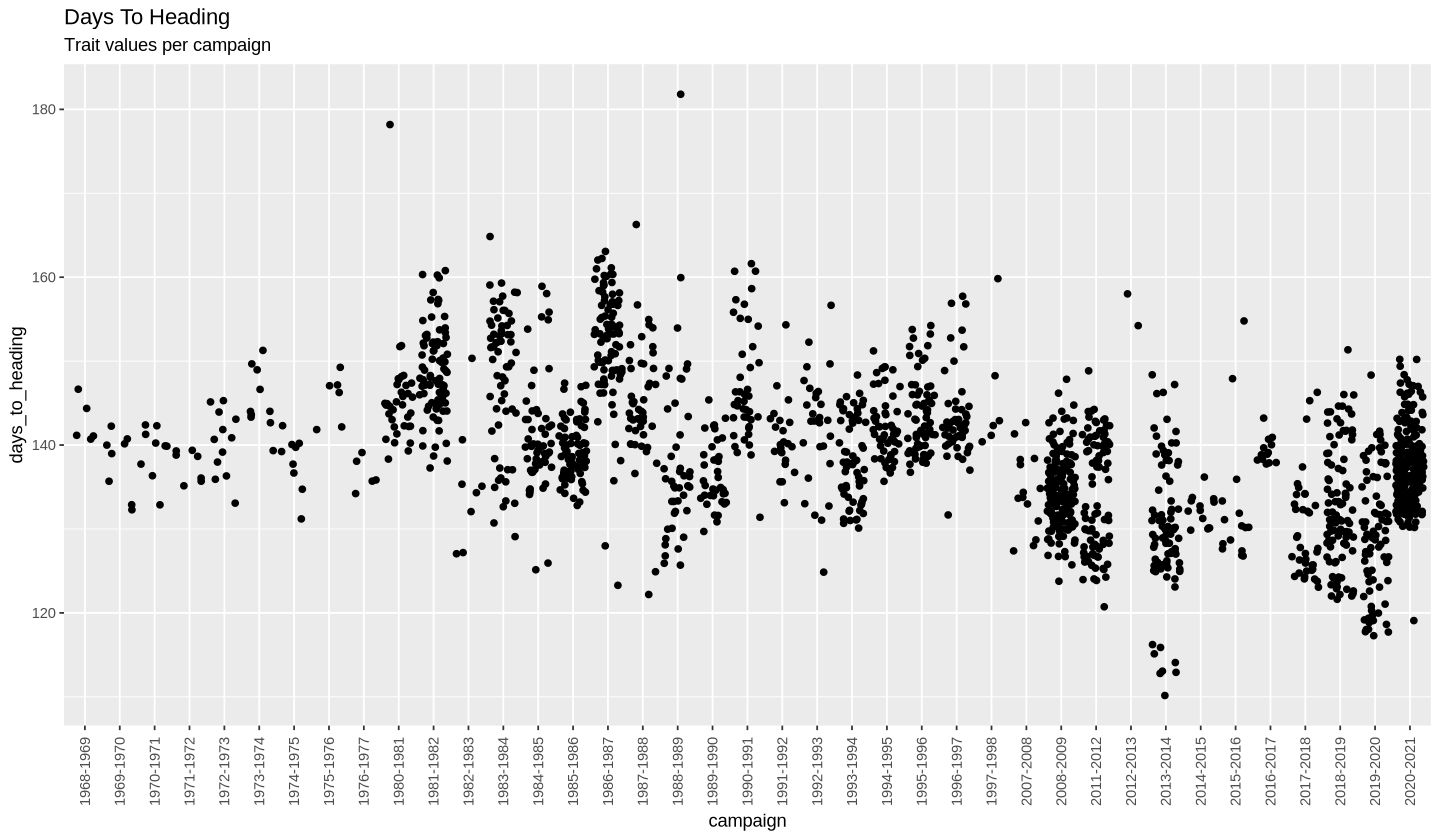

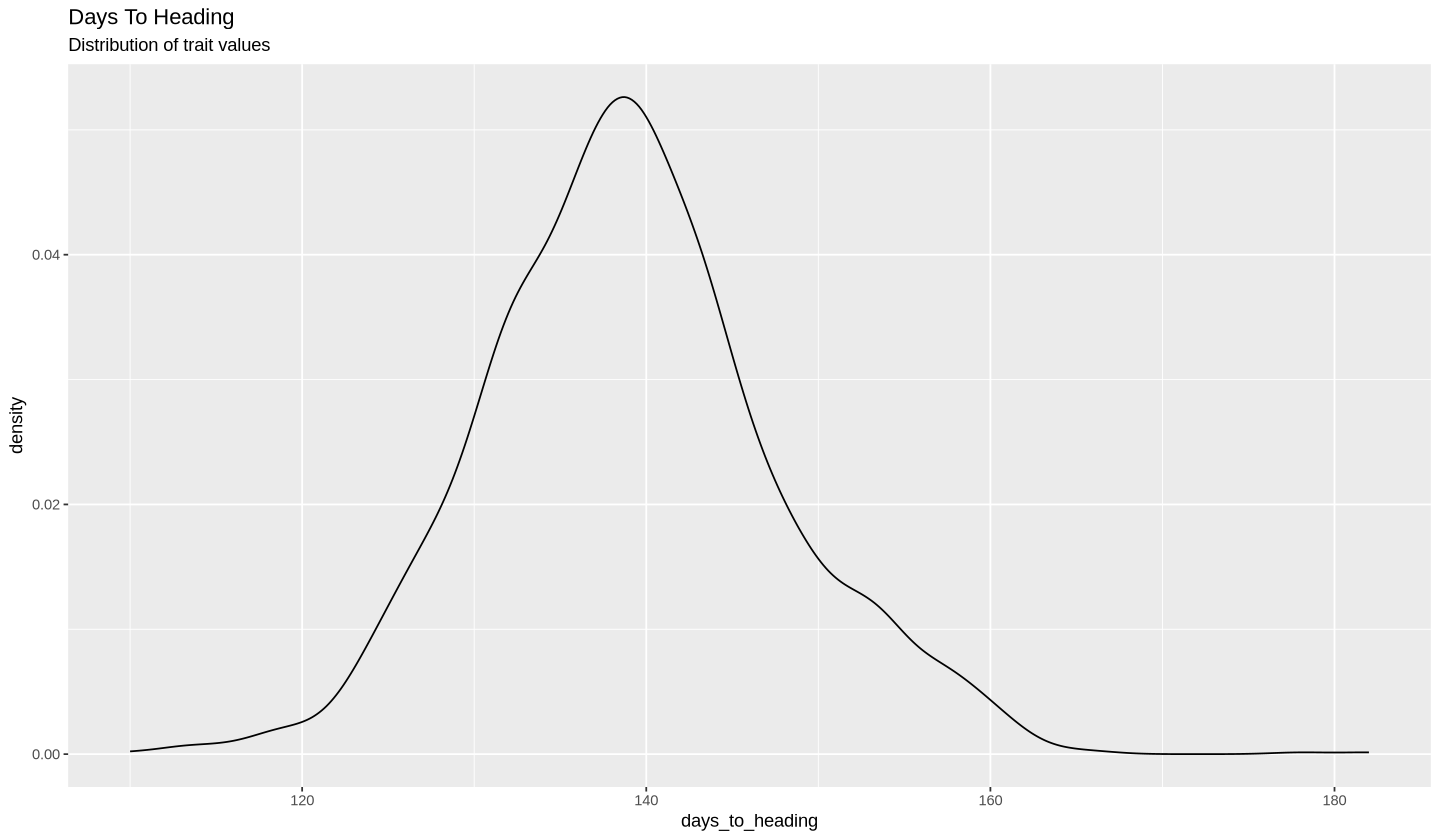

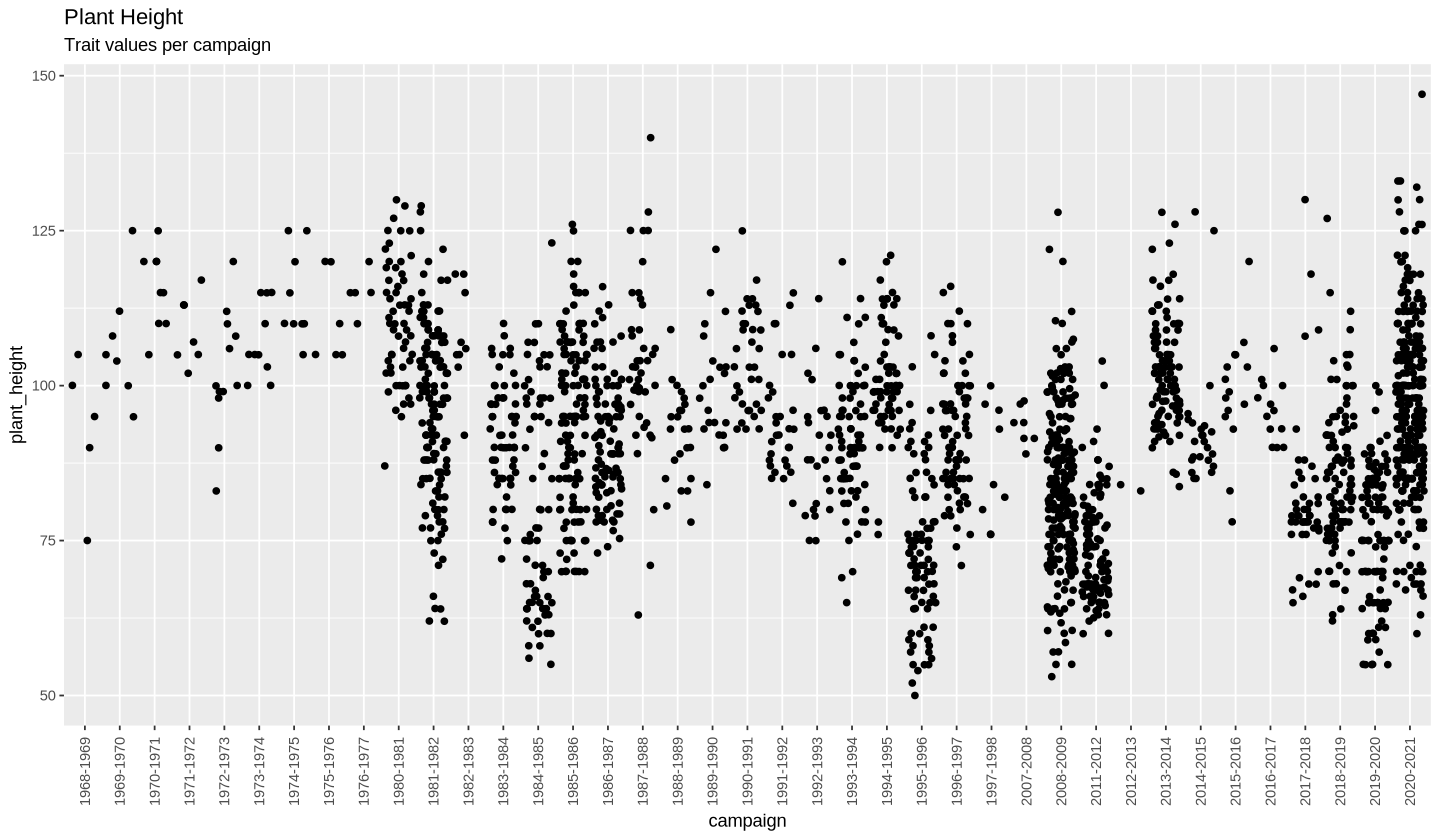

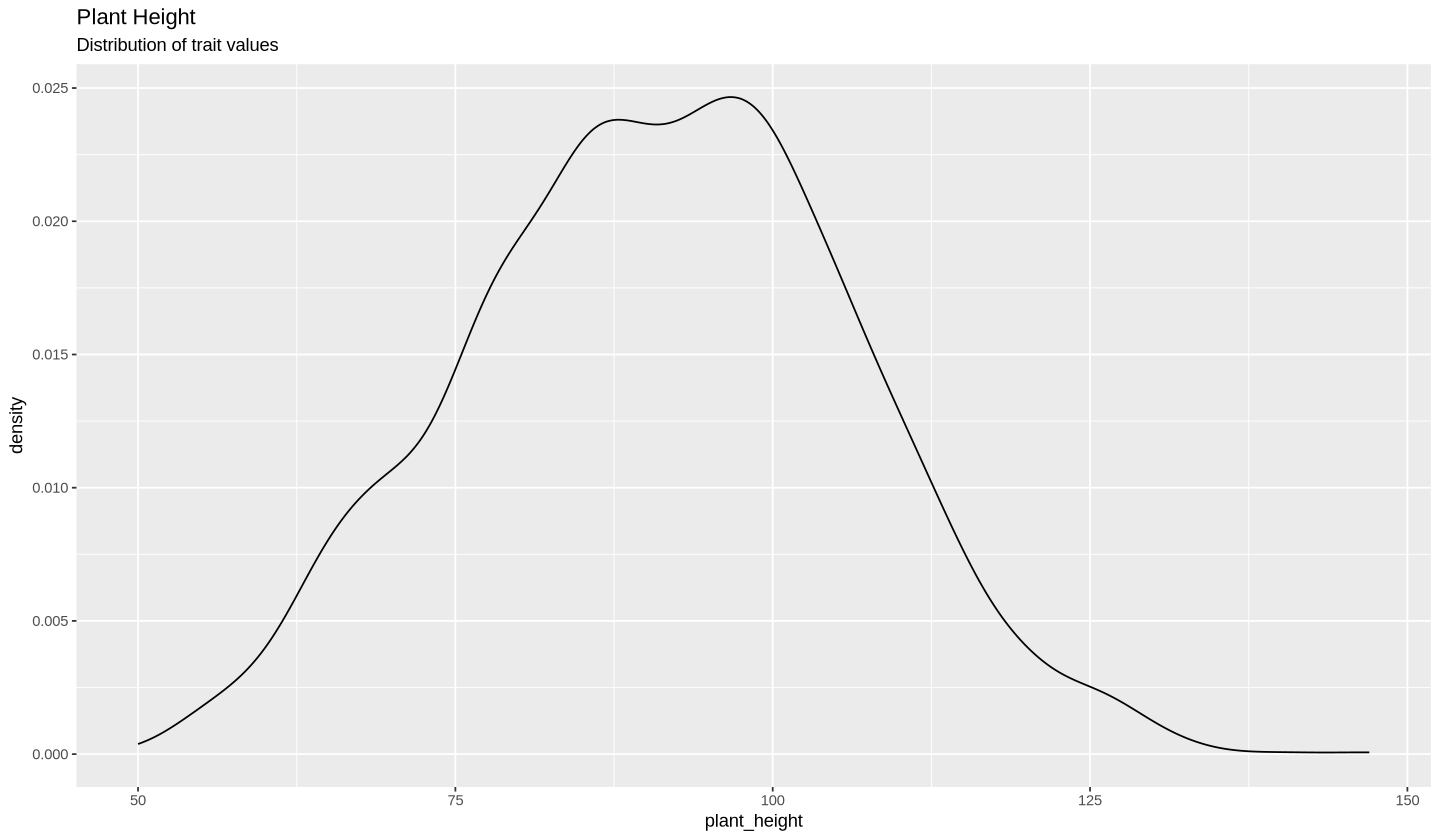

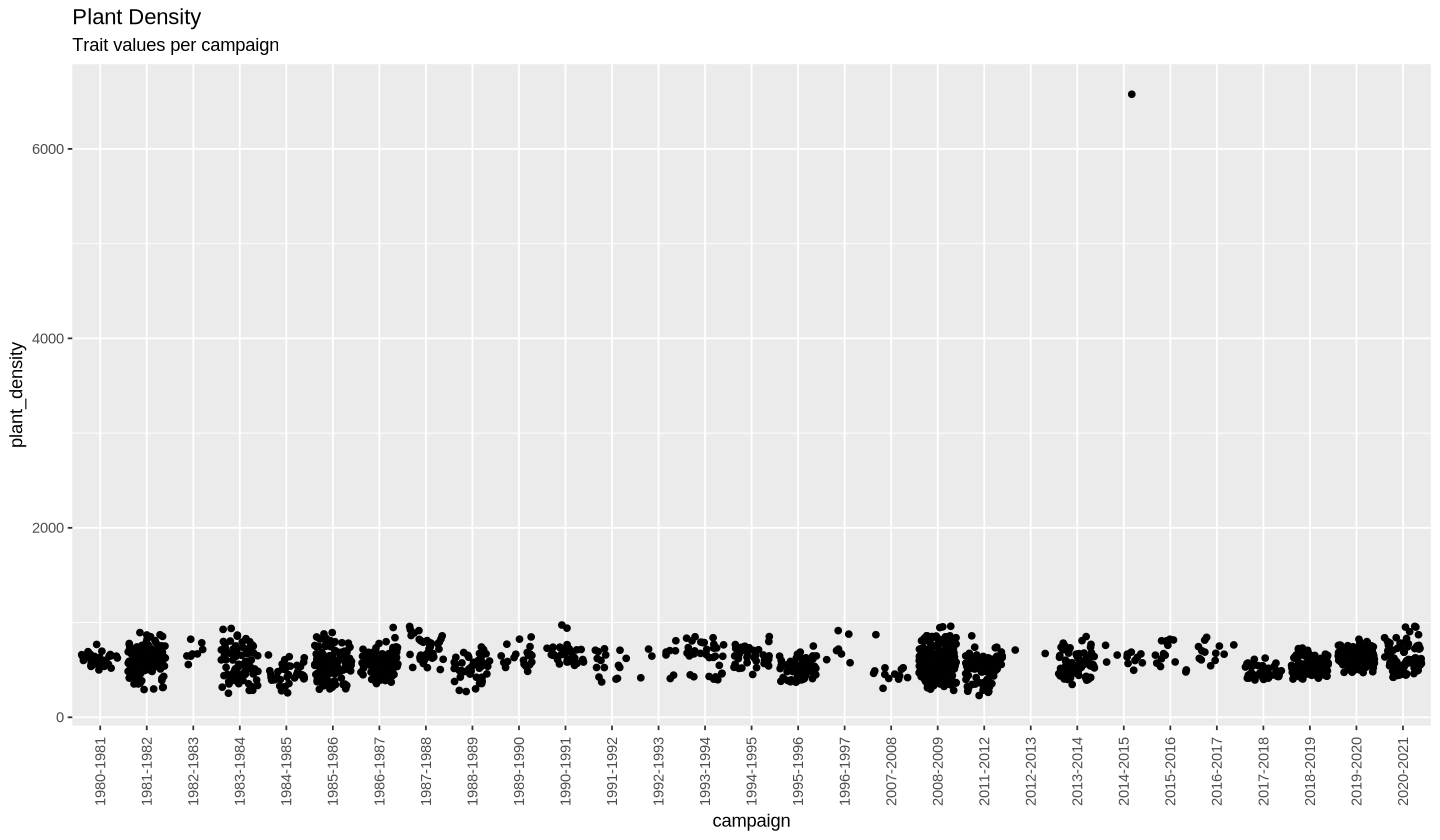

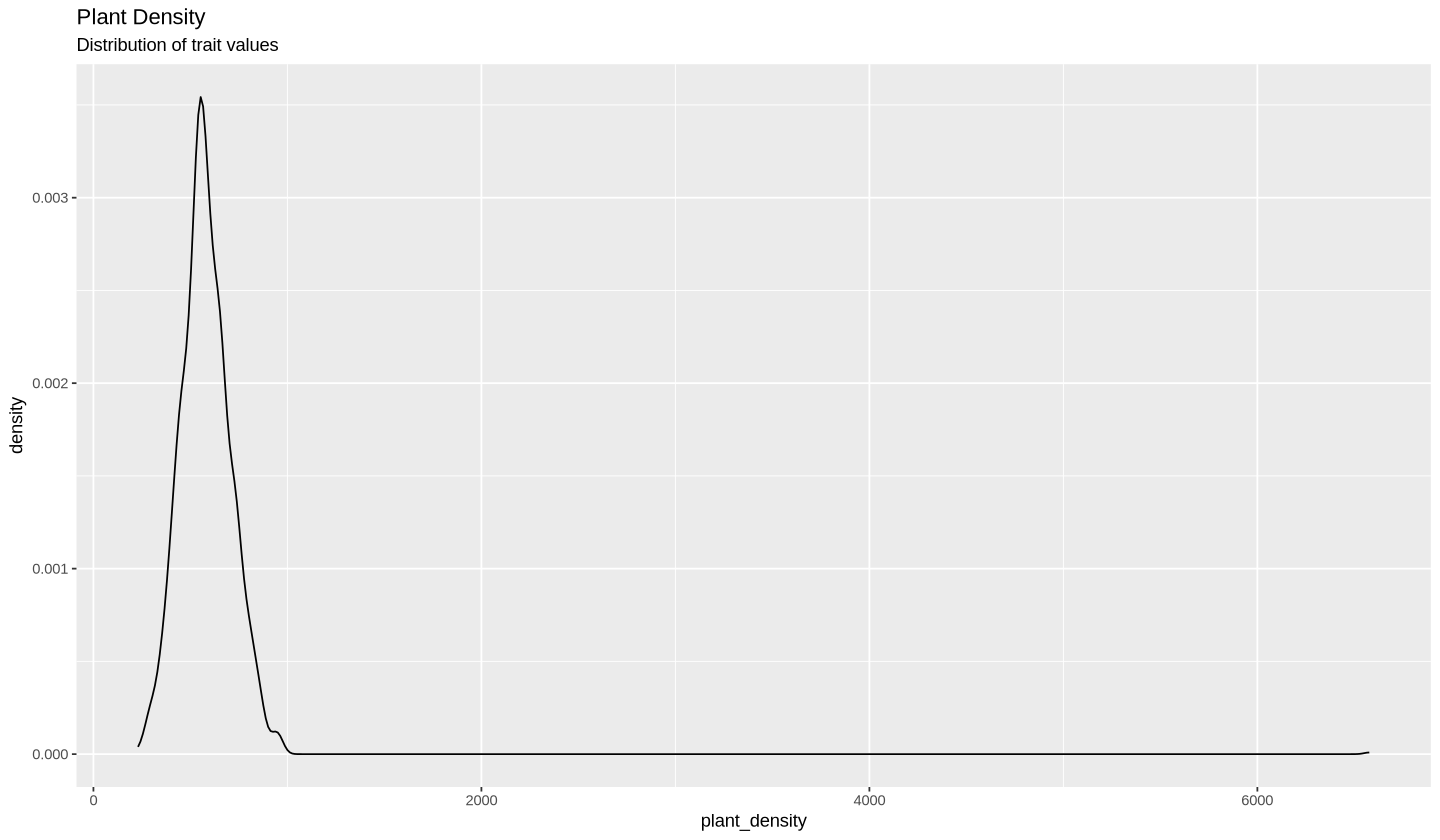

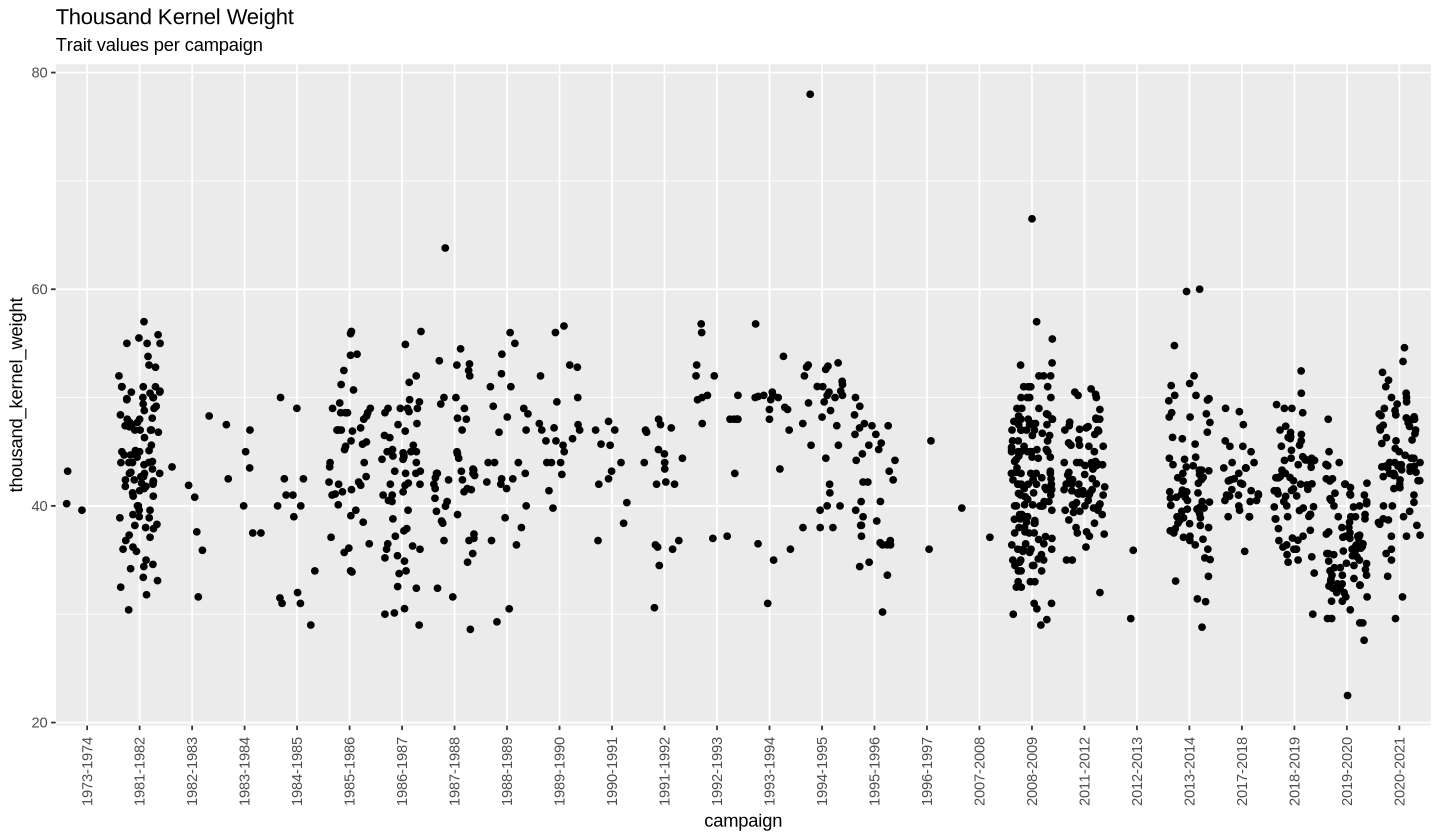

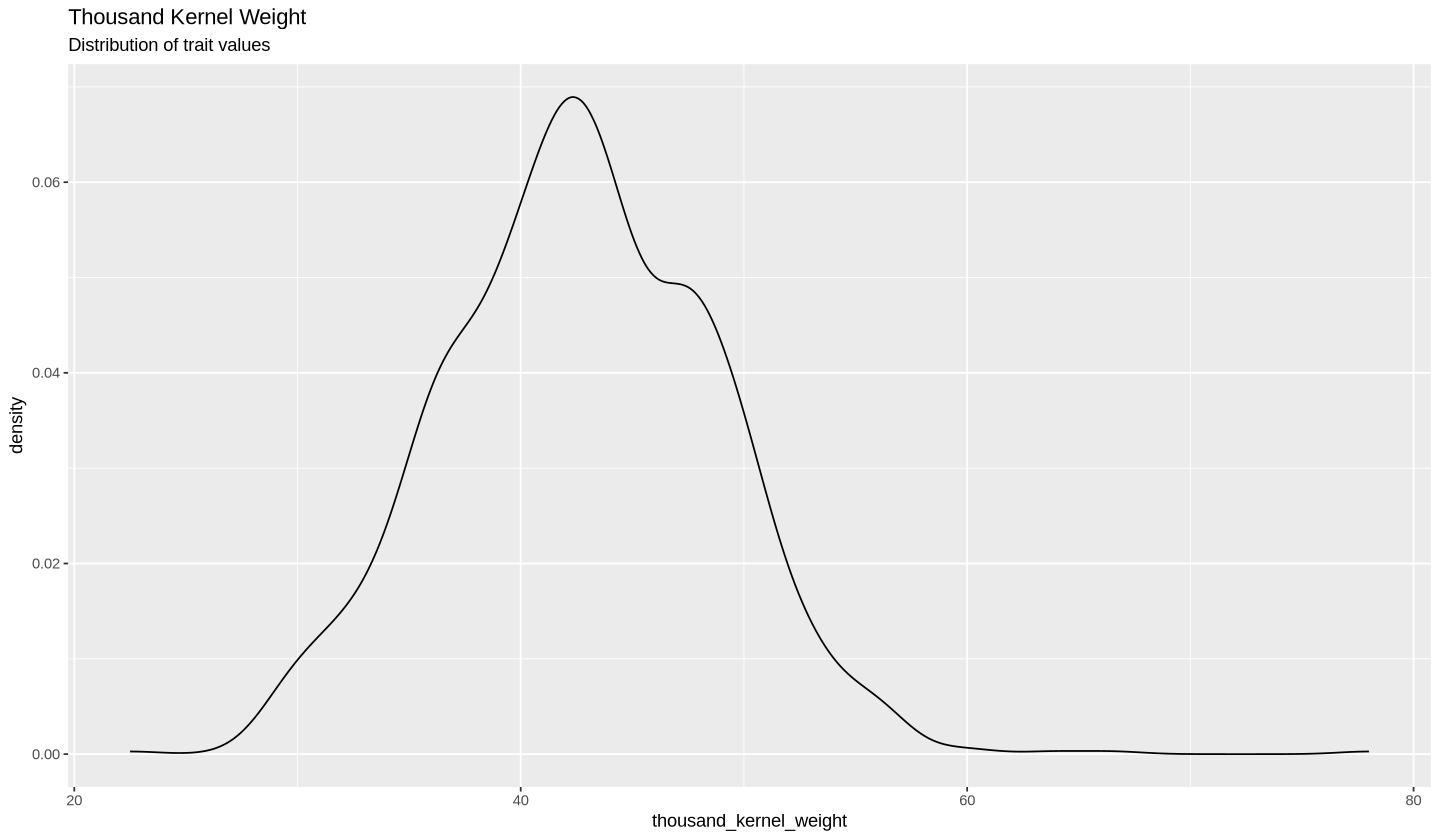

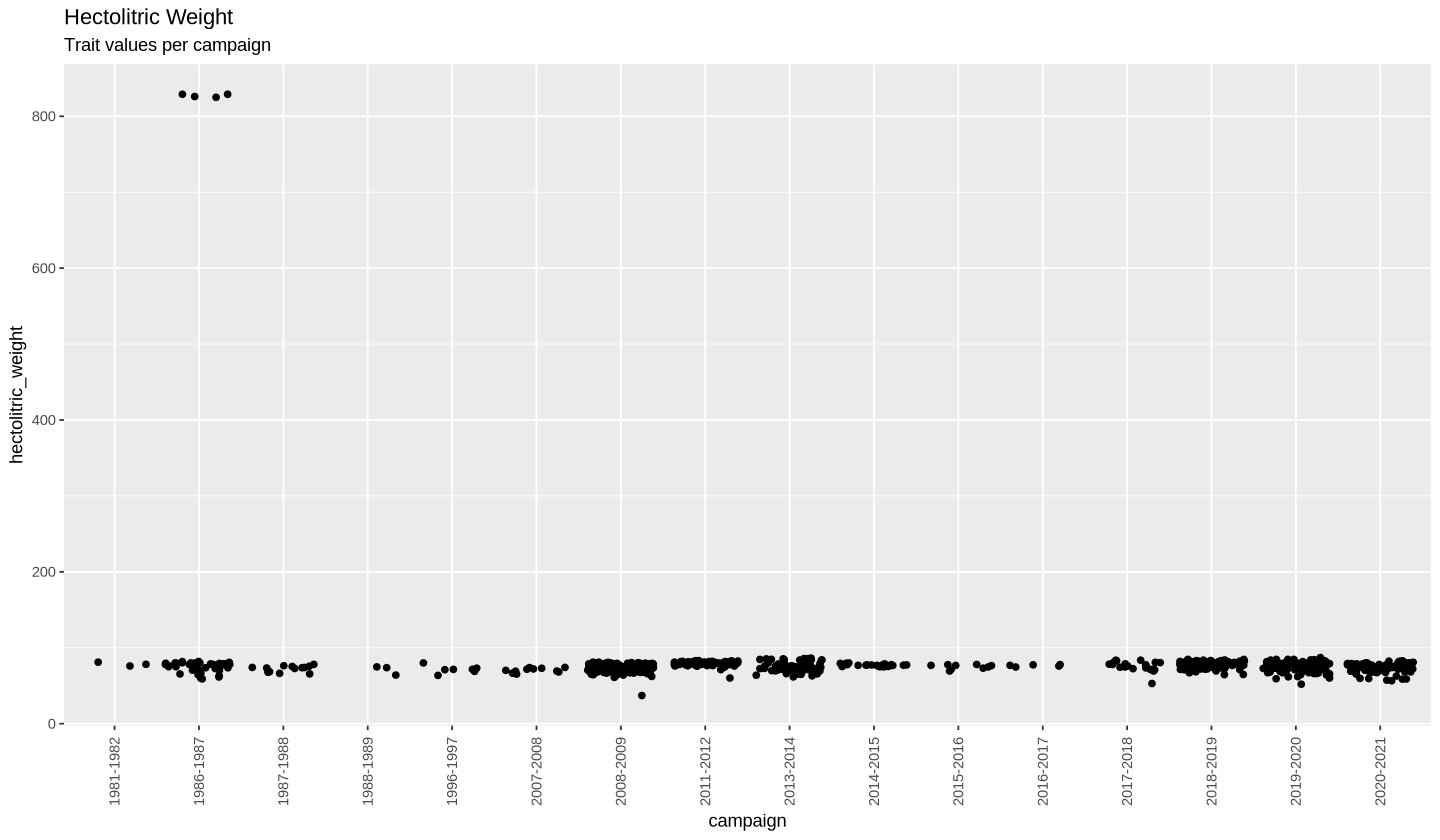

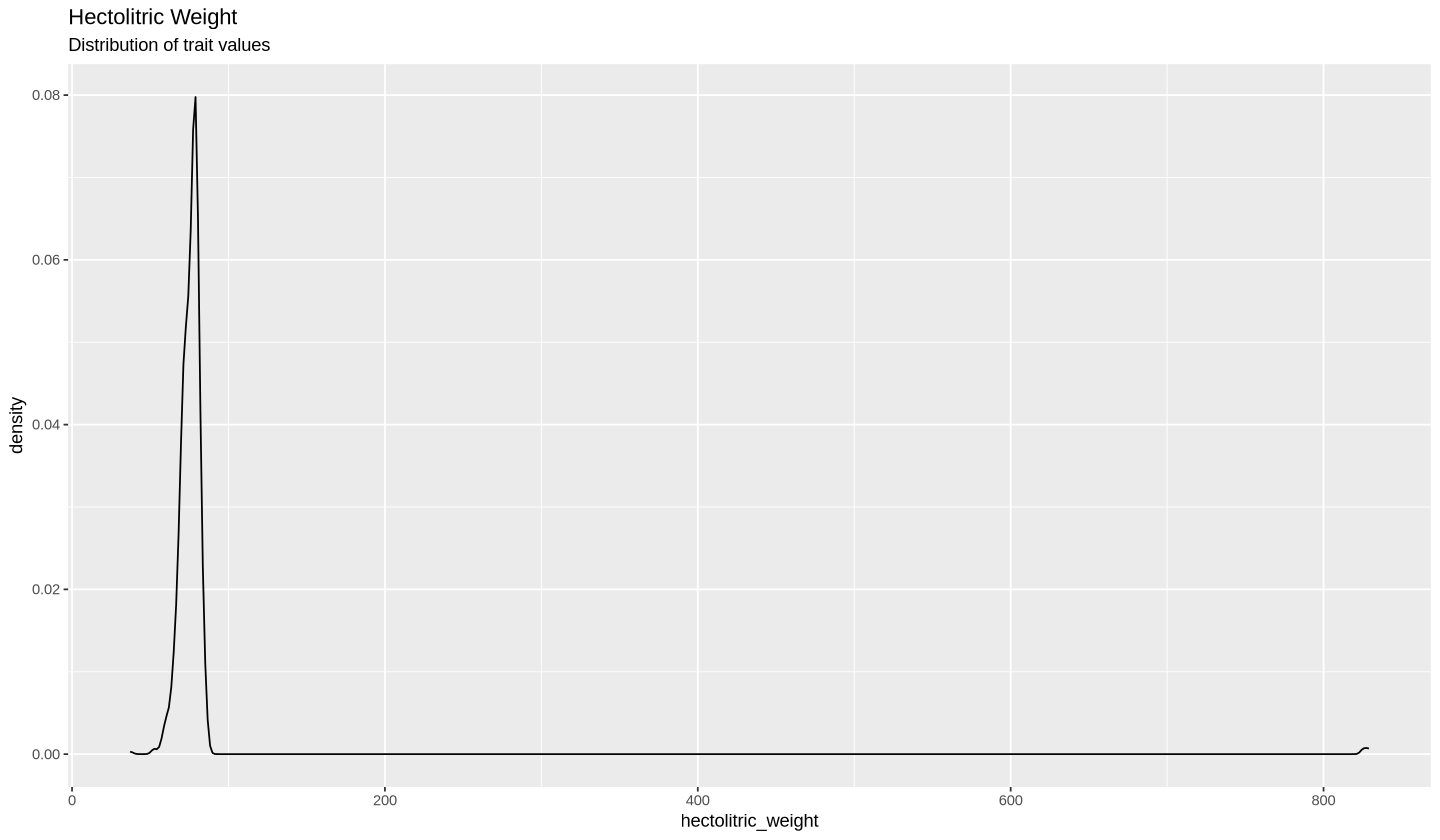

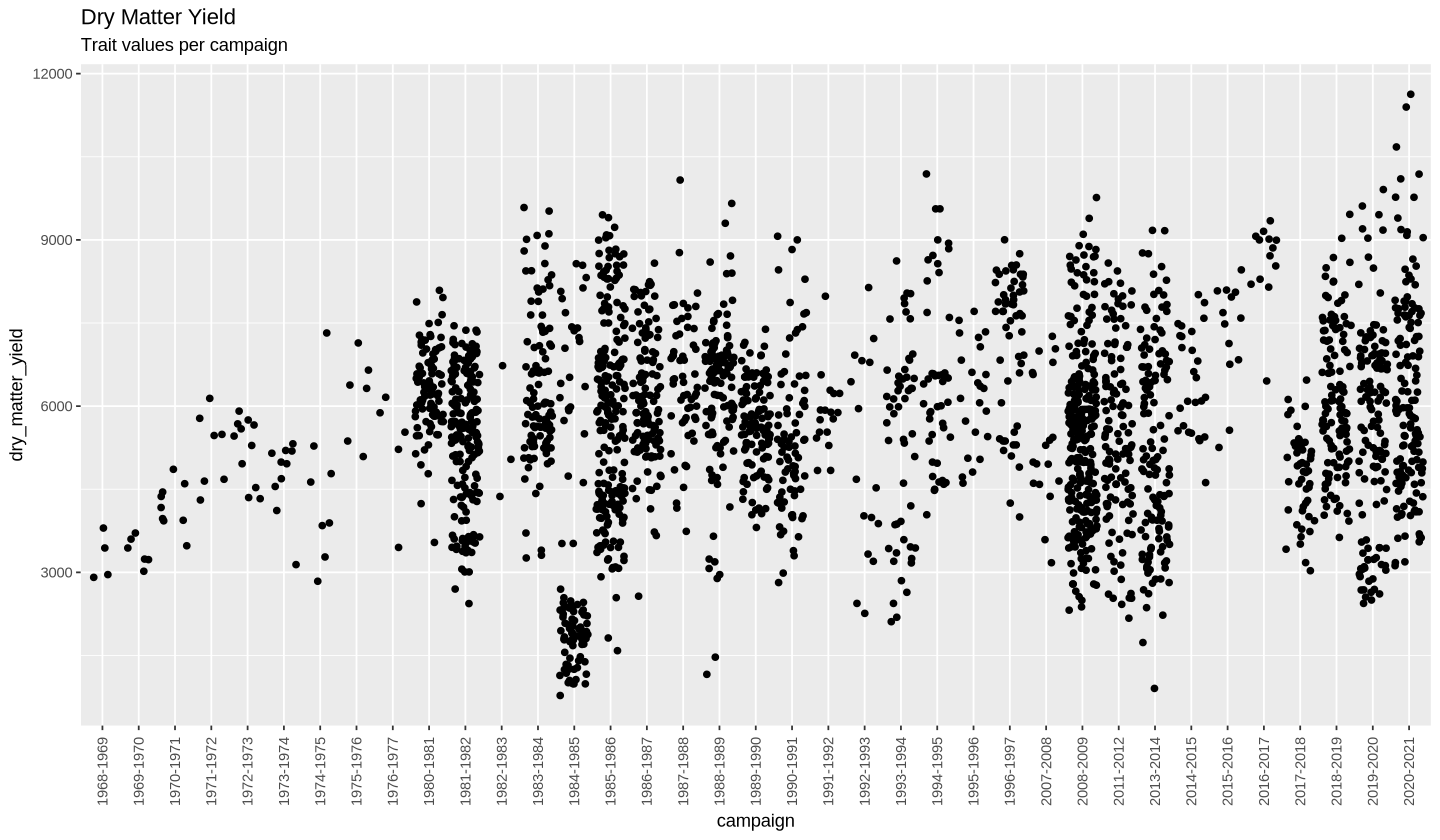

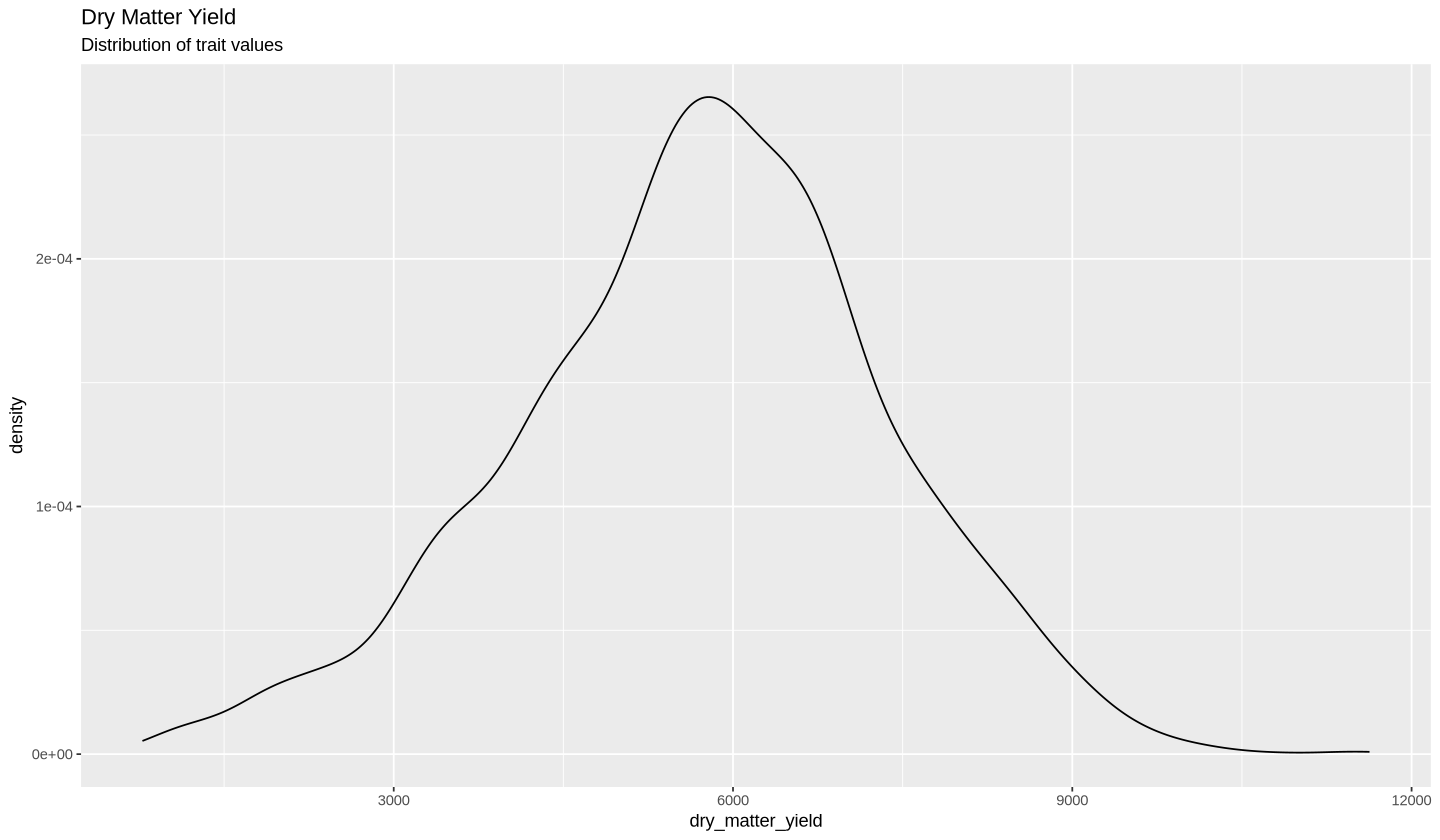

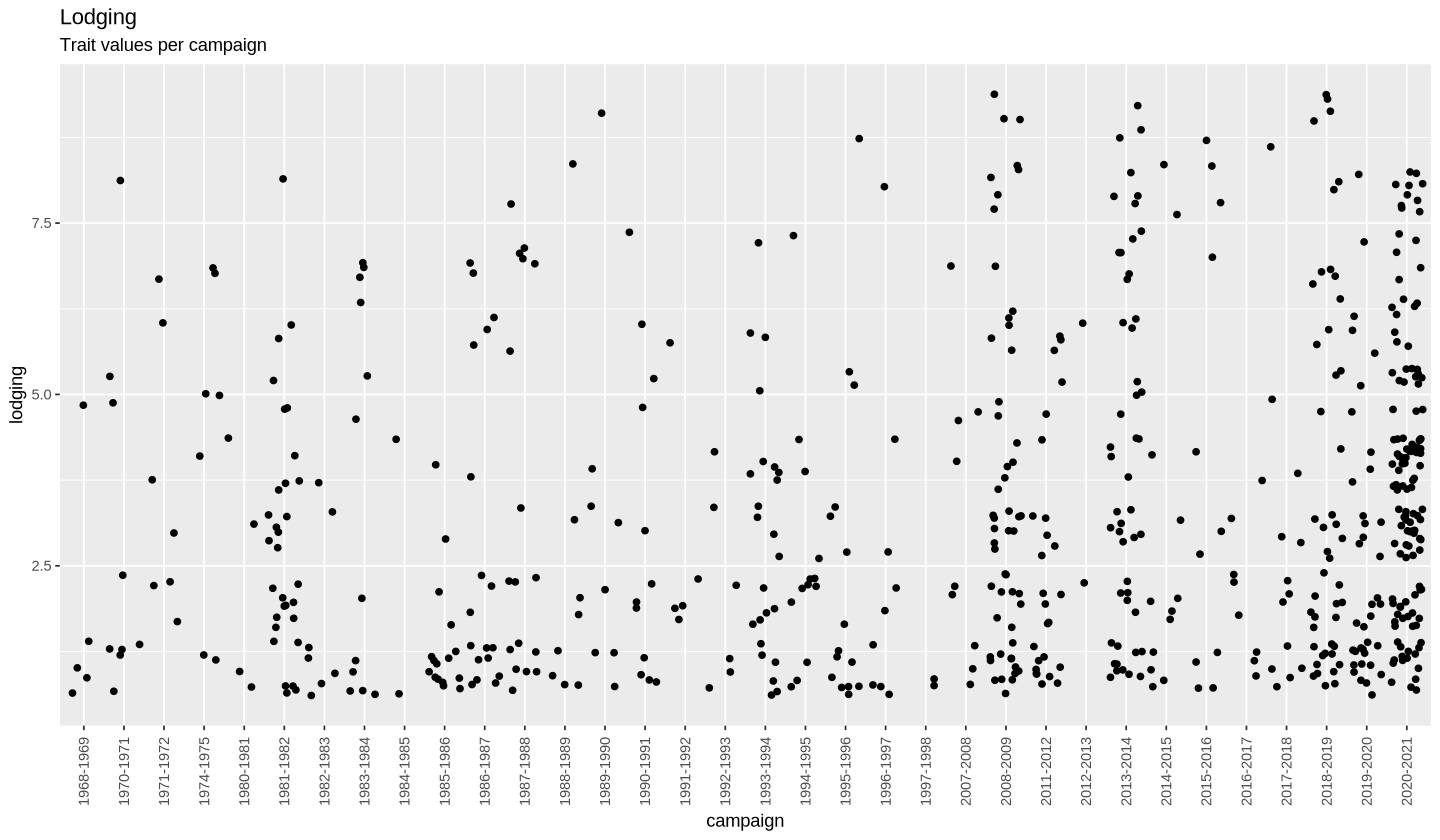

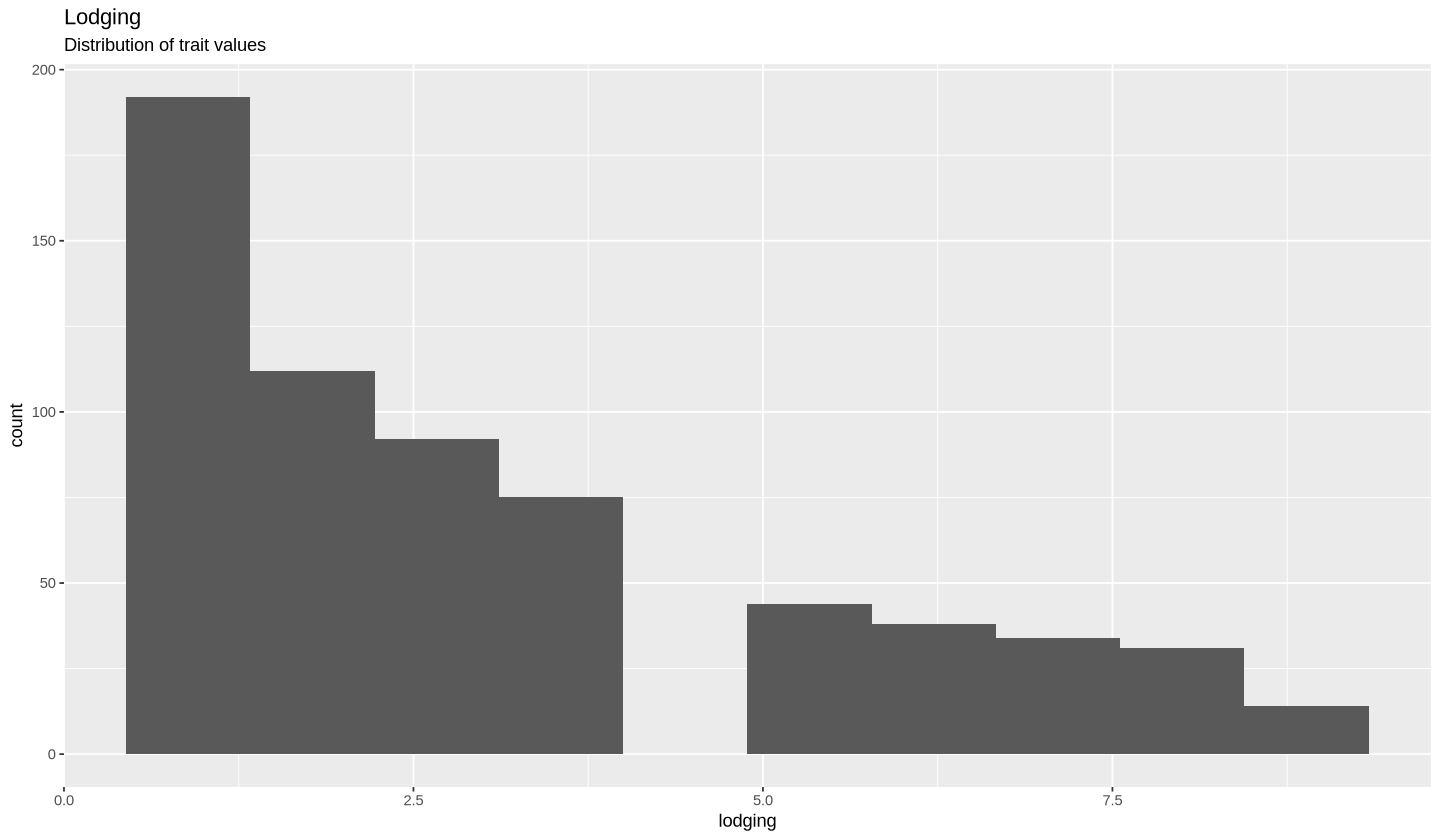

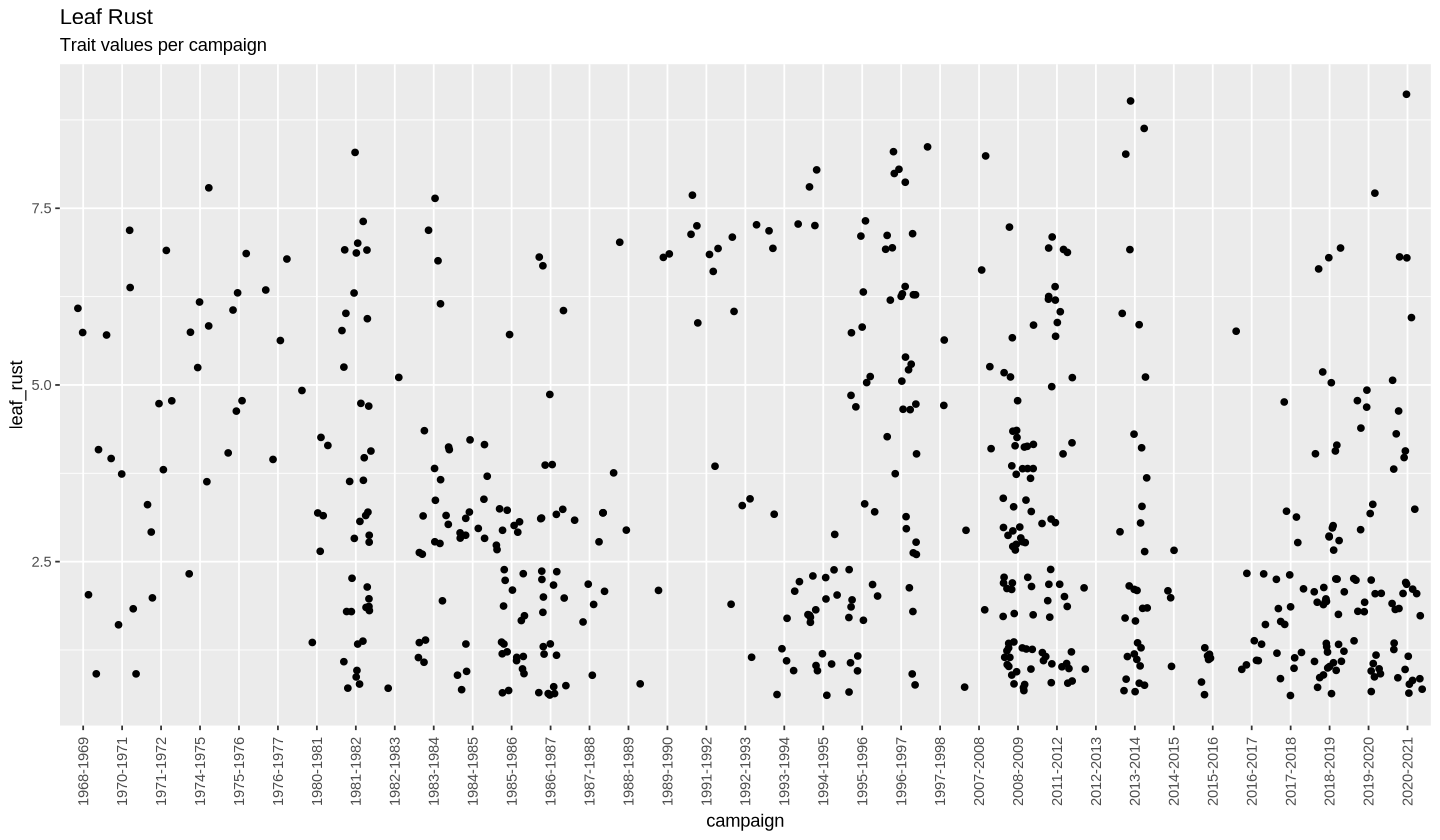

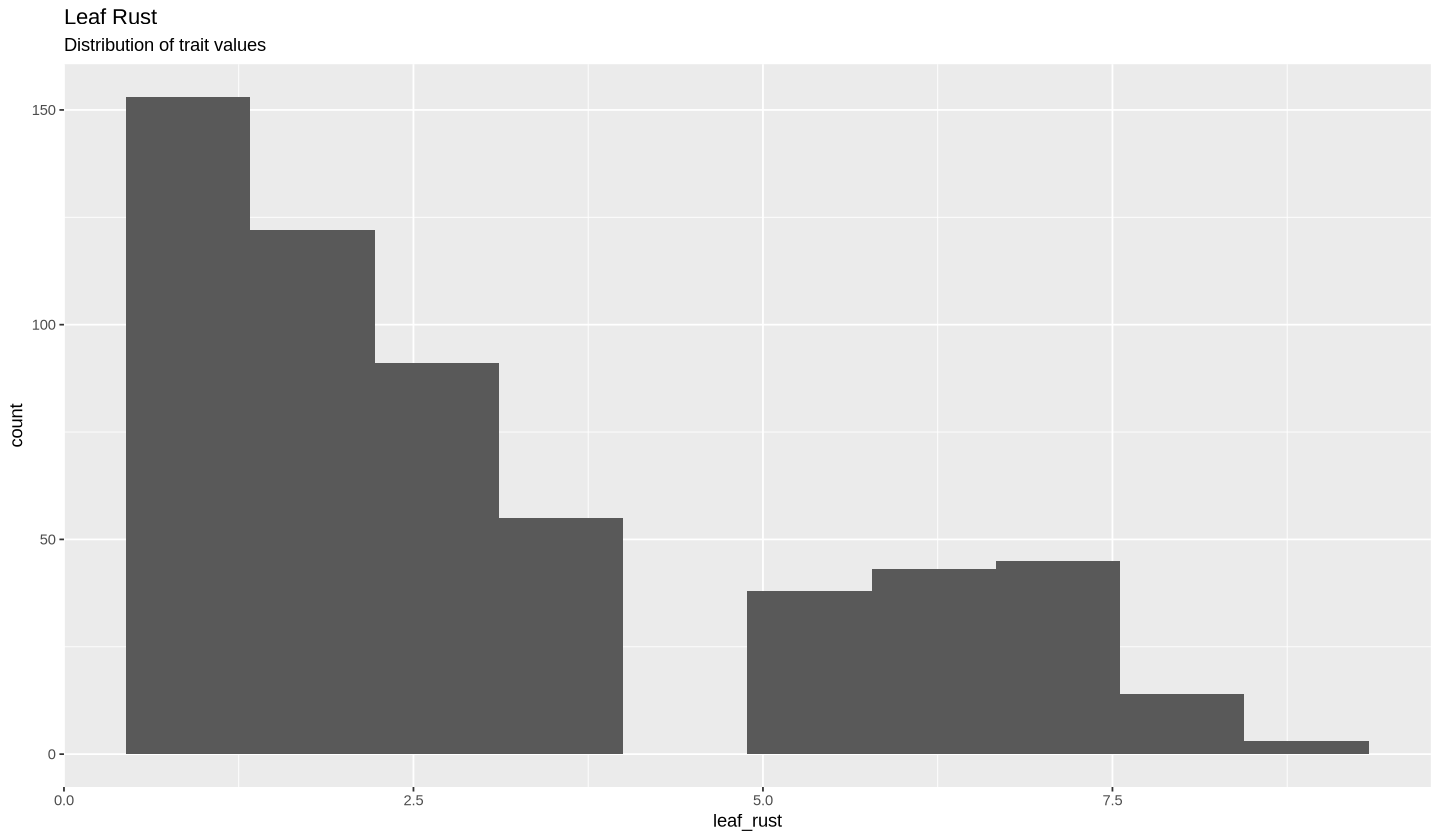

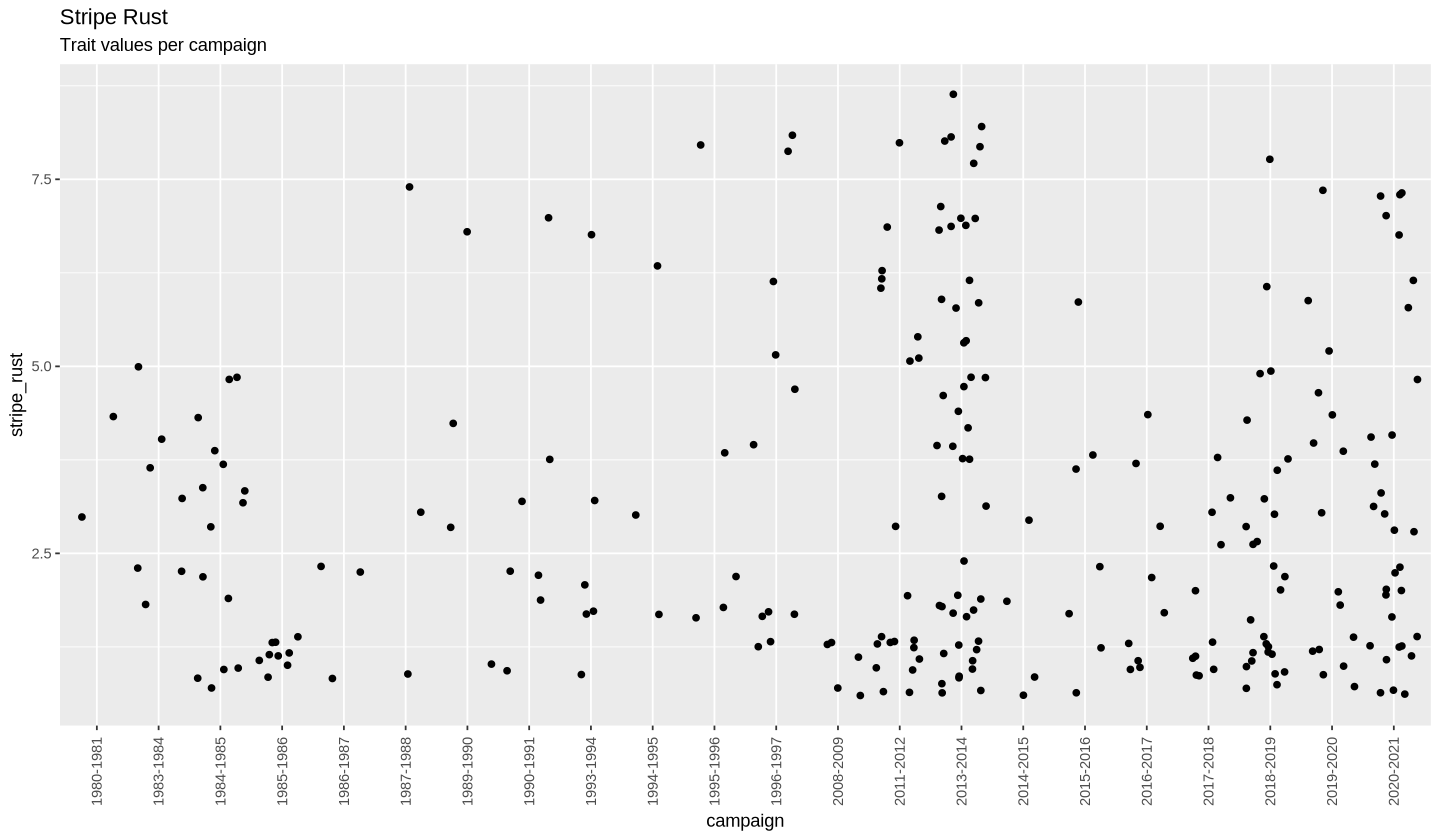

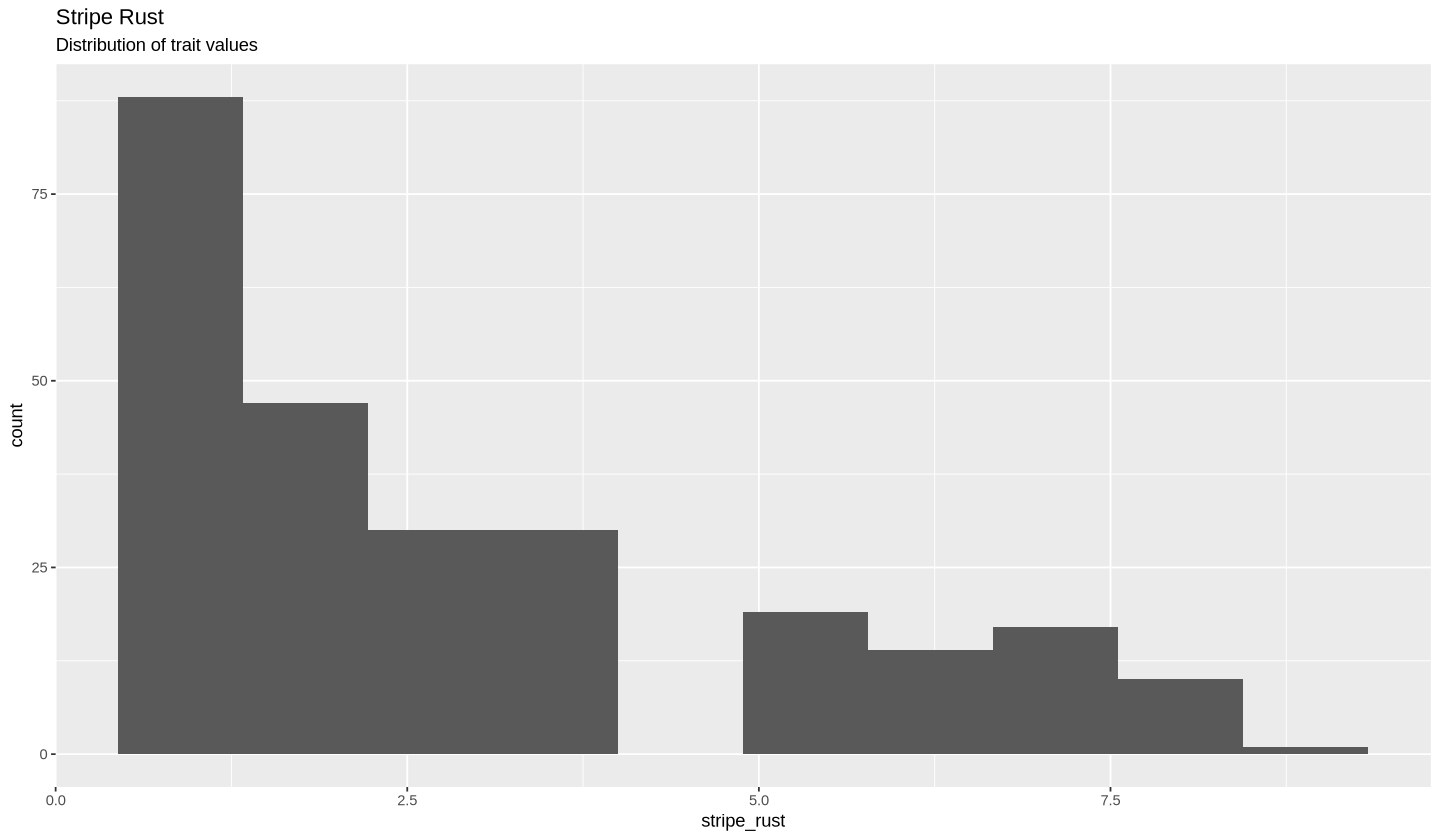

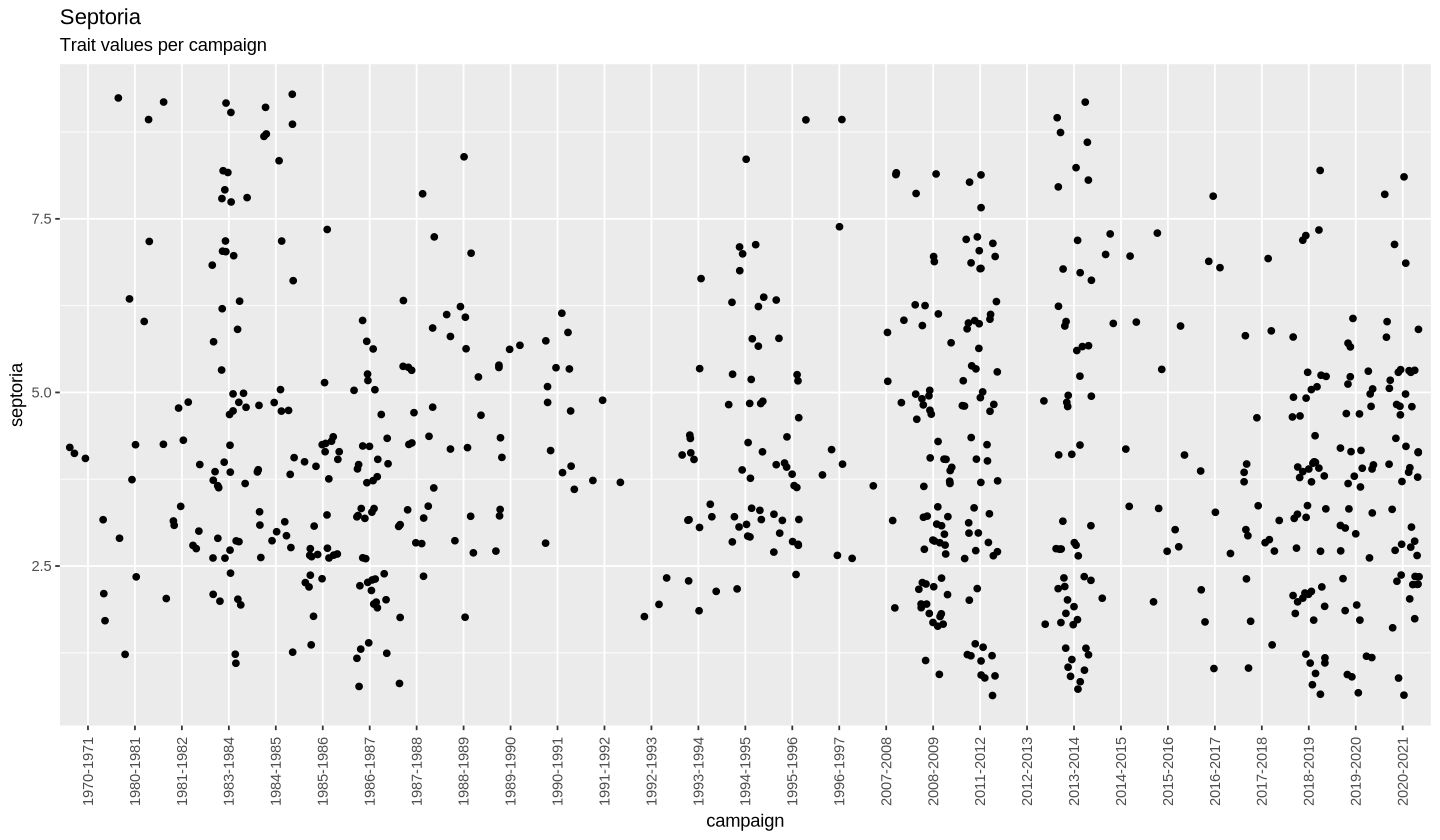

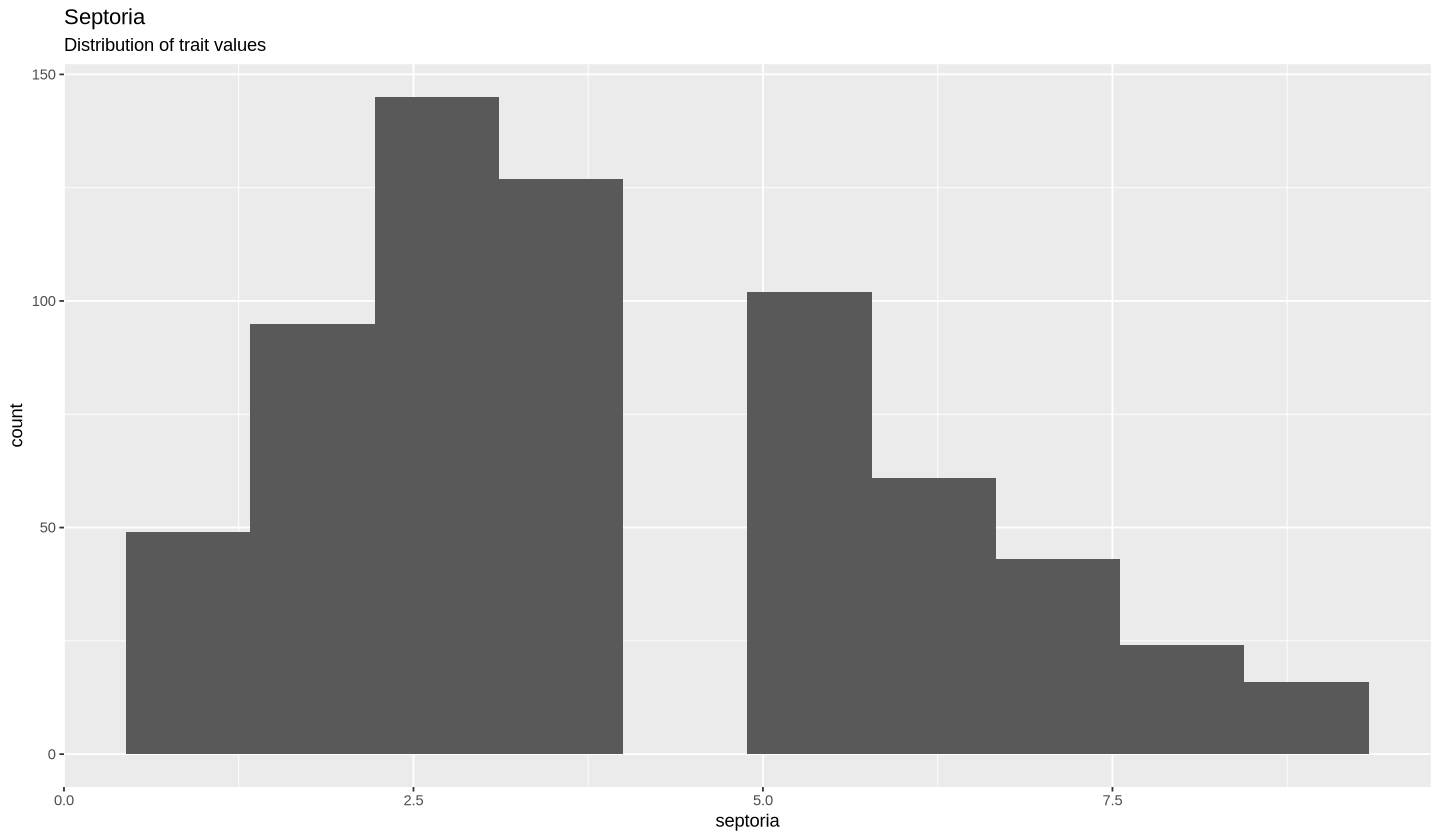

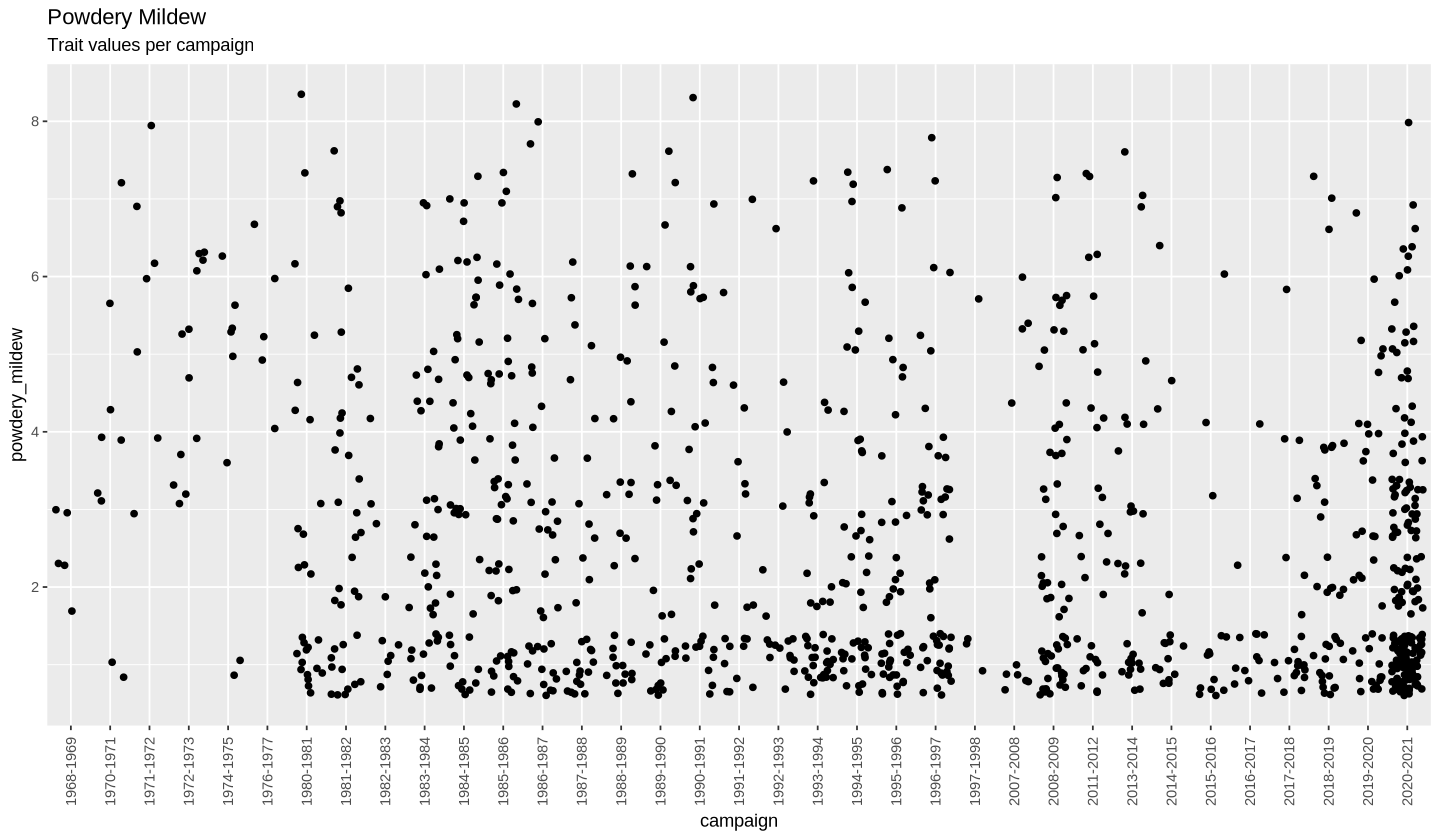

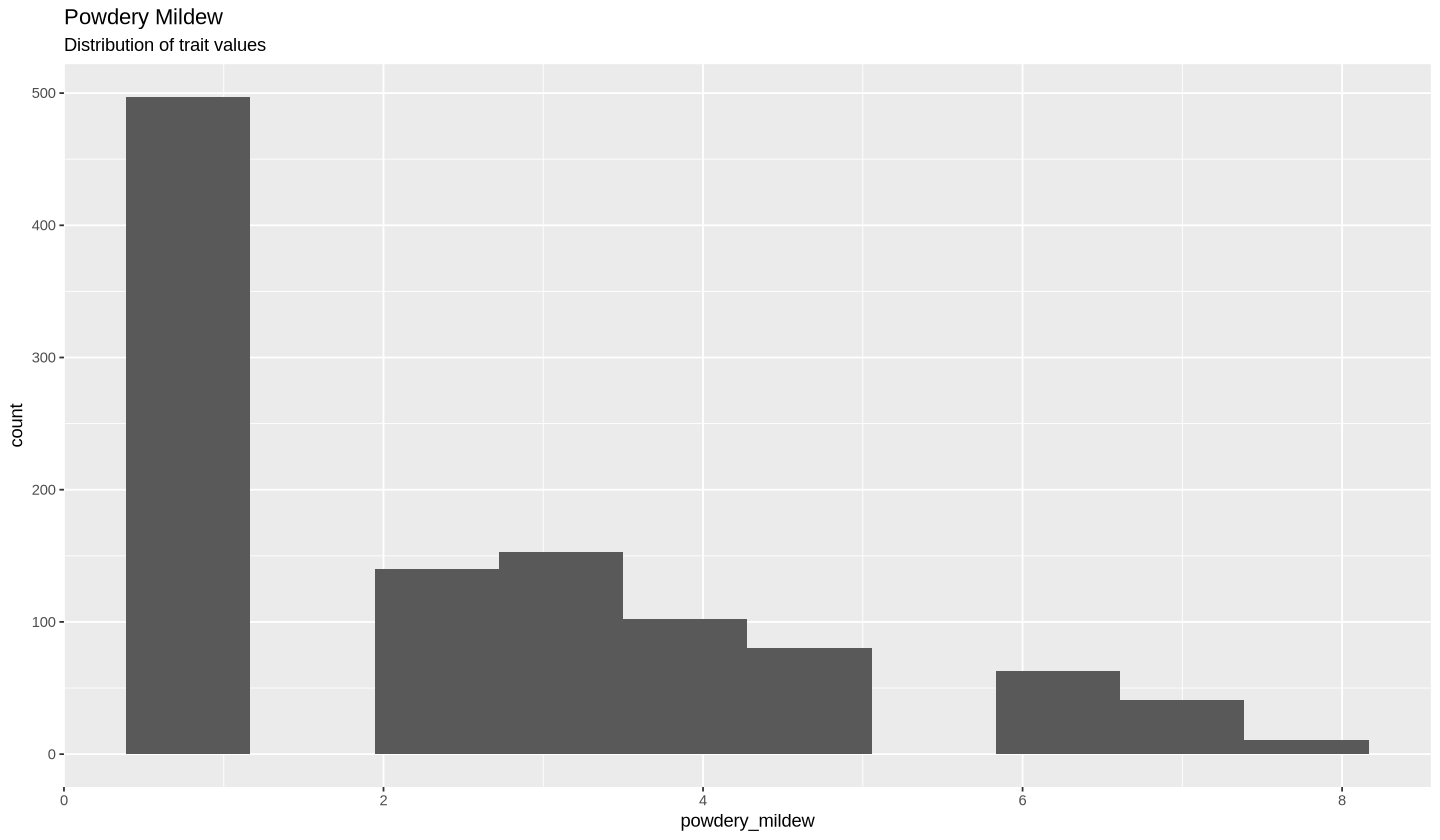

In [4]:
options(repr.plot.width=12, repr.plot.height=7)
data_sub_HT |> visualise_trait(geom_density())
data_sub_PH |> visualise_trait(geom_density())
data_sub_PD |> visualise_trait(geom_density())
data_sub_TKW |> visualise_trait(geom_density())
data_sub_HW |> visualise_trait(geom_density())
data_sub_DMY |> visualise_trait(geom_density())
data_sub_L |> visualise_trait(geom_histogram(bins=10))
data_sub_LR |> visualise_trait(geom_histogram(bins=10))
data_sub_SR |> visualise_trait(geom_histogram(bins=10))
data_sub_ST |> visualise_trait(geom_histogram(bins=10))
data_sub_PM |> visualise_trait(geom_histogram(bins=10))

## Extract and format the campaign effects

In [5]:
asreml_campaign_HT <- asreml(fixed = days_to_heading ~campaign, random = ~accenumb, 
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign),
                             data = data_sub_HT)

In [6]:
asreml_campaign_PH <- asreml(fixed = plant_height ~campaign, random = ~accenumb,
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                             data = data_sub_PH)

Warning message in asreml(fixed = plant_height ~ campaign, random = ~accenumb, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration”


In [7]:
asreml_campaign_PD <- asreml(fixed = plant_density ~campaign, random = ~accenumb,
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                             data = data_sub_PD)

In [8]:
asreml_campaign_TKW <- asreml(fixed = thousand_kernel_weight ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_TKW)

Warning message in asreml(fixed = thousand_kernel_weight ~ campaign, random = ~accenumb, :
“Some components changed by more than 1% on the last iteration”


In [9]:
asreml_campaign_HW <- asreml(fixed = hectolitric_weight ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_HW)

In [10]:
asreml_campaign_DMY <- asreml(fixed = dry_matter_yield ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_DMY)

Warning message in asreml(fixed = dry_matter_yield ~ campaign, random = ~accenumb, :
“Some components changed by more than 1% on the last iteration”


In [11]:
asreml_campaign_PM <- asreml(fixed = powdery_mildew ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_PM)

In [12]:
campaign_effect_HT <- get_campaign_effect(asreml_campaign_HT)
campaign_effect_PH <- get_campaign_effect(asreml_campaign_PH)
campaign_effect_PD <- get_campaign_effect(asreml_campaign_PD)
campaign_effect_TKW <- get_campaign_effect(asreml_campaign_TKW)
campaign_effect_HW <- get_campaign_effect(asreml_campaign_HW)
campaign_effect_DMY <- get_campaign_effect(asreml_campaign_DMY)
campaign_effect_PM <- get_campaign_effect(asreml_campaign_PM)

## Extract heterogeneous error variances

In [13]:
error_var_HT <- get_error_var(asreml_campaign_HT)
error_var_PH <- get_error_var(asreml_campaign_PH)
error_var_PD <- get_error_var(asreml_campaign_PD)
error_var_TKW <- get_error_var(asreml_campaign_TKW)
error_var_HW <- get_error_var(asreml_campaign_HW)
error_var_DMY <- get_error_var(asreml_campaign_DMY)
error_var_PM <- get_error_var(asreml_campaign_PM)

## Calculate and standardize the coefficient of variation (CV)

In [14]:
CV_df_HT <- make_CV_df(campaign_effect_HT, error_var_HT)
CV_df_PH <- make_CV_df(campaign_effect_PH, error_var_PH)
CV_df_PD <- make_CV_df(campaign_effect_PD, error_var_PD)
CV_df_TKW <- make_CV_df(campaign_effect_TKW, error_var_TKW)
CV_df_HW <- make_CV_df(campaign_effect_HW, error_var_HW)
CV_df_DMY <- make_CV_df(campaign_effect_DMY, error_var_DMY)
CV_df_PM <- make_CV_df(campaign_effect_PM, error_var_PM)

## Remove outlier campaigns

In [15]:
data_corrected_HT_I <- data_sub_HT |> correct_I(CV_df_HT)
data_corrected_PH_I <- data_sub_PH |> correct_I(CV_df_PH)
data_corrected_PD_I <- data_sub_PD |> correct_I(CV_df_PD)
data_corrected_TKW_I <- data_sub_TKW |> correct_I(CV_df_TKW)
data_corrected_HW_I <- data_sub_HW |> correct_I(CV_df_HW)
data_corrected_DMY_I <- data_sub_DMY |> correct_I(CV_df_DMY)
data_corrected_PM_I <- data_sub_PM |> correct_I(CV_df_PM)

0 outlier campaign(s) detected for trait days_to_heading


0 outlier campaign(s) detected for trait plant_height


1 outlier campaign(s) detected for trait plant_density: 2014-2015 


1 outlier campaign(s) detected for trait thousand_kernel_weight: 2012-2013 


1 outlier campaign(s) detected for trait hectolitric_weight: 1986-1987 


0 outlier campaign(s) detected for trait dry_matter_yield


1 outlier campaign(s) detected for trait powdery_mildew: 1997-1998 


## Residuals

In [16]:
asreml_res_HT <- asreml(fixed = days_to_heading ~ accenumb, random = ~ campaign,
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_HT_I)

Warning message in asreml(fixed = days_to_heading ~ accenumb, random = ~campaign, :
“Warning : Log-likelihood decreased to -4053.38; trying with reduced updates 0.270556”


Warning message in asreml(fixed = days_to_heading ~ accenumb, random = ~campaign, :
“Warning : Log-likelihood decreased to -3726.20; trying with reduced updates 0.109086”


Warning message in asreml(fixed = days_to_heading ~ accenumb, random = ~campaign, :
“Log-likelihood not converged”


Warning message in asreml(fixed = days_to_heading ~ accenumb, random = ~campaign, :
“Some components changed by more than 1% on the last iteration”


In [17]:
asreml_res_PH <- asreml(fixed = plant_height ~ accenumb, random = ~ campaign, 
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_PH_I)

In [18]:
asreml_res_PD <- asreml(fixed = plant_density ~ accenumb, random = ~ campaign, 
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_PD_I)

In [19]:
asreml_res_TKW <- asreml(fixed = thousand_kernel_weight ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_TKW_I)

Warning message in asreml(fixed = thousand_kernel_weight ~ accenumb, random = ~campaign, :
“Some components changed by more than 1% on the last iteration”


In [20]:
asreml_res_DMY <- asreml(fixed = dry_matter_yield ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_DMY_I)

In [21]:
asreml_res_PM <- asreml(fixed = powdery_mildew ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_PM_I)

Warning message in asreml(fixed = powdery_mildew ~ accenumb, random = ~campaign, :
“Some components changed by more than 1% on the last iteration”


12 outlier value(s) detected for trait Days To Heading 


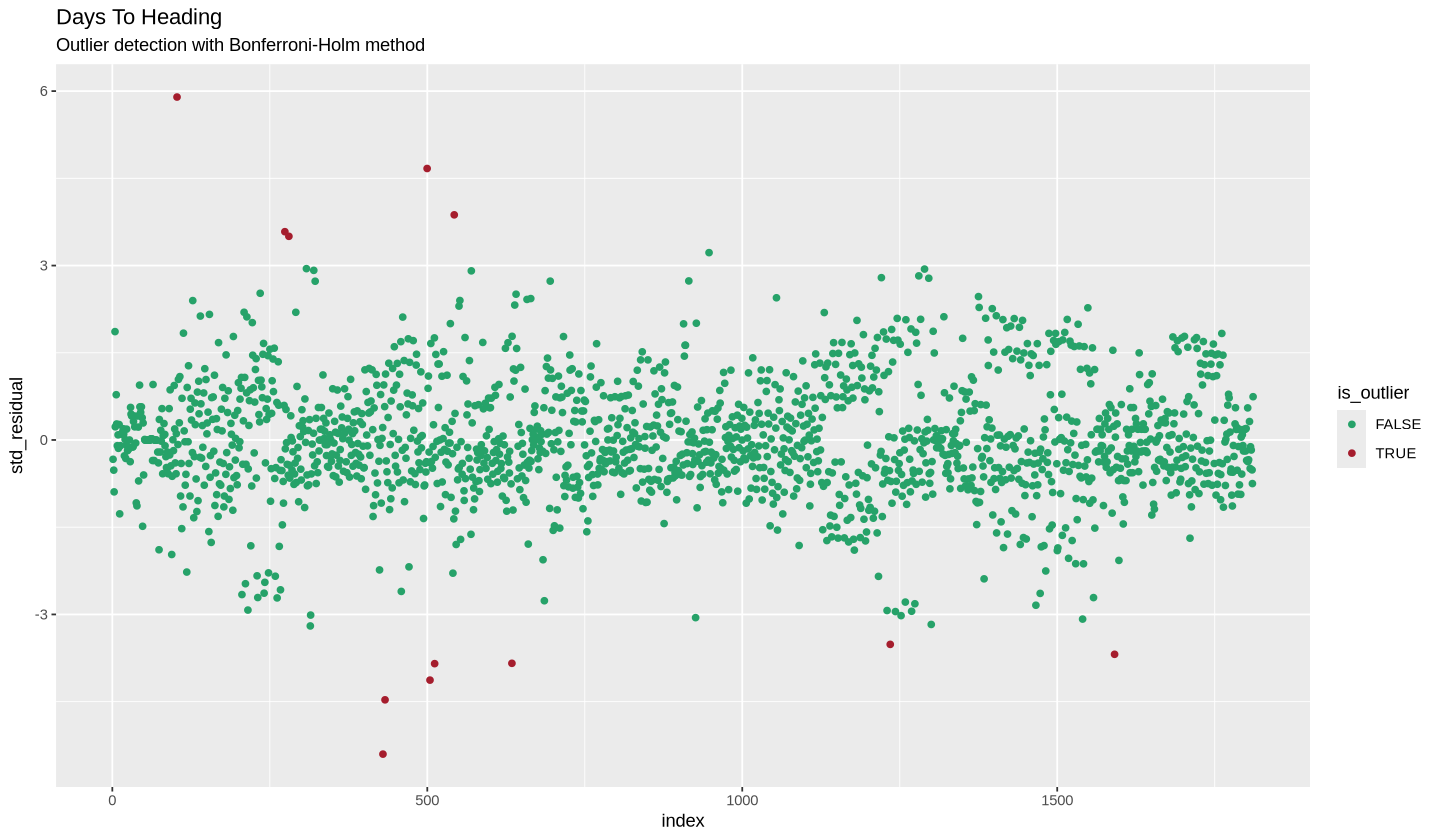

In [22]:
result_BH_HT <- make_BH_multtest(asreml_res_HT)

2 outlier value(s) detected for trait Plant Height 


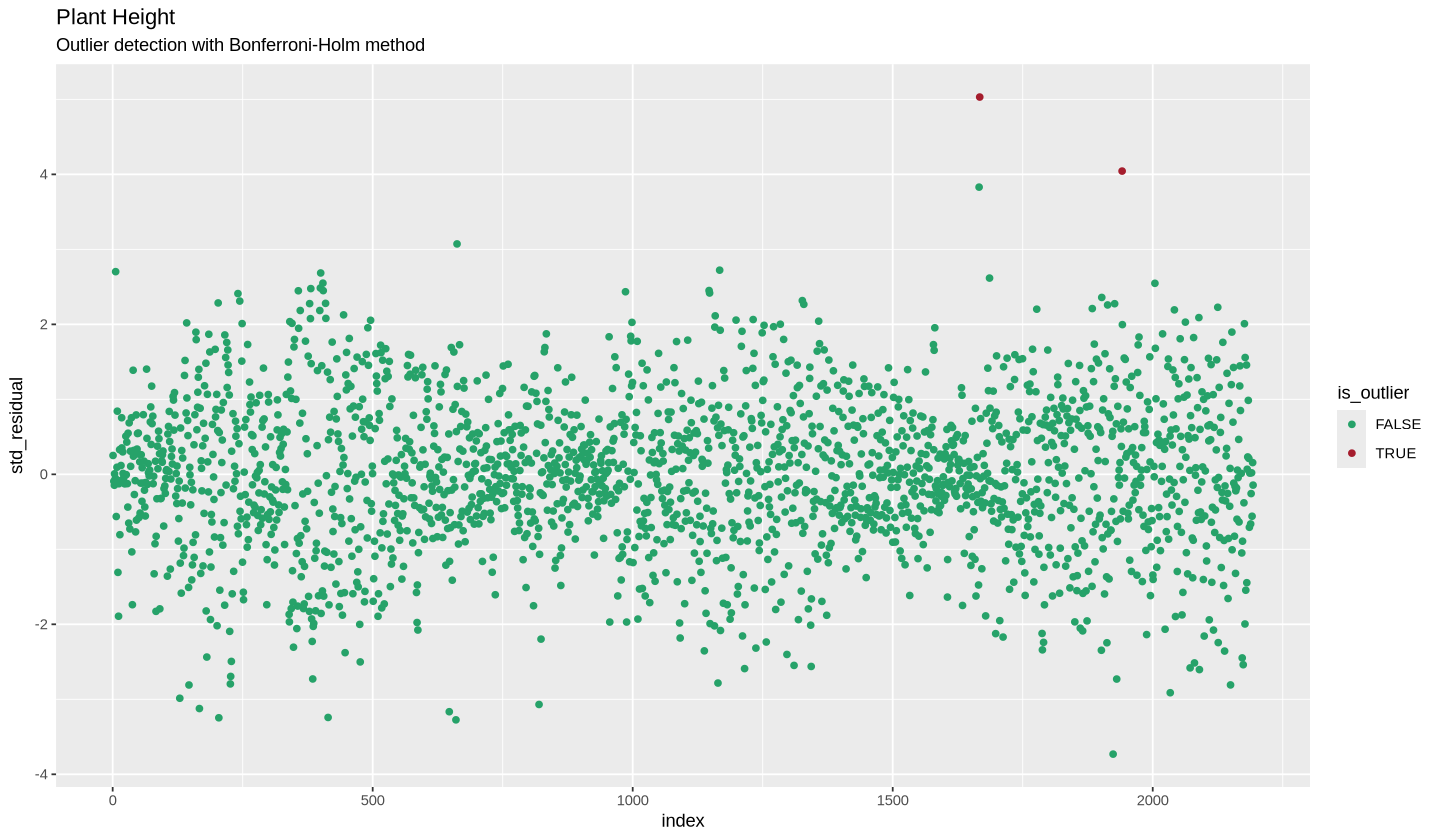

In [23]:
result_BH_PH <- make_BH_multtest(asreml_res_PH)

0 outlier value(s) detected for trait Plant Density 


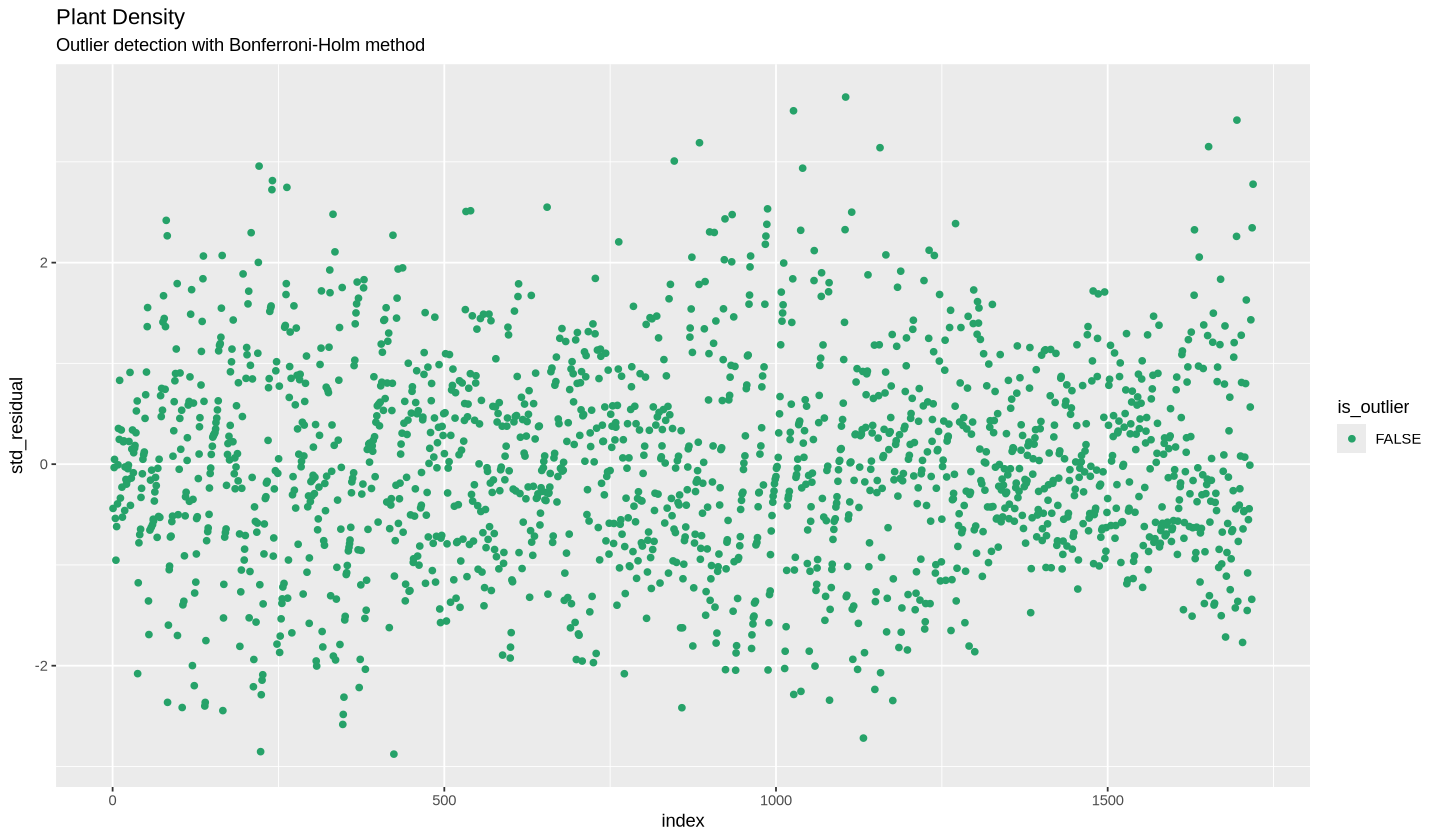

In [24]:
result_BH_PD <- make_BH_multtest(asreml_res_PD)

2 outlier value(s) detected for trait Thousand Kernel Weight 


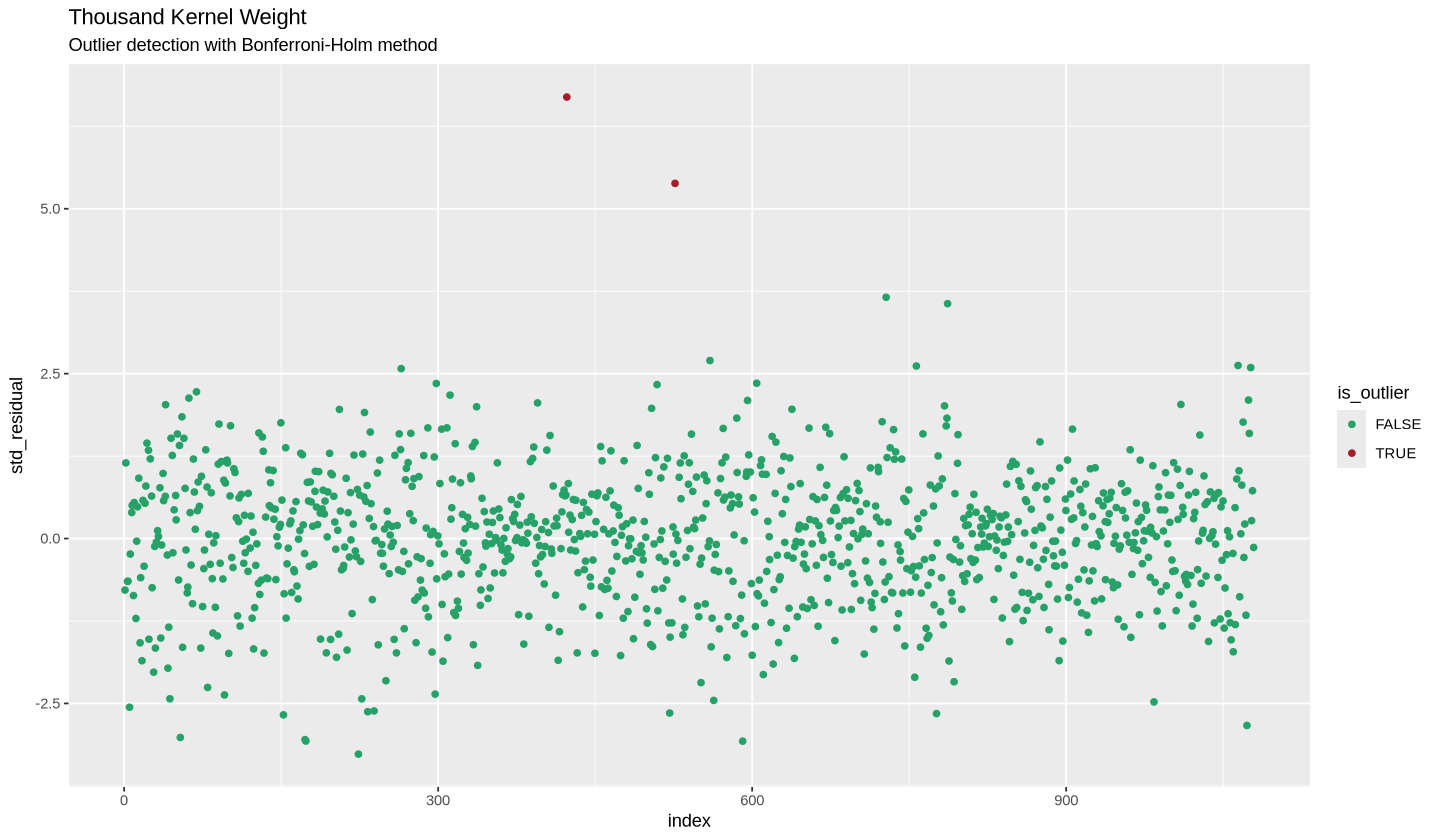

In [25]:
result_BH_TKW <- make_BH_multtest(asreml_res_TKW)

1 outlier value(s) detected for trait Dry Matter Yield 


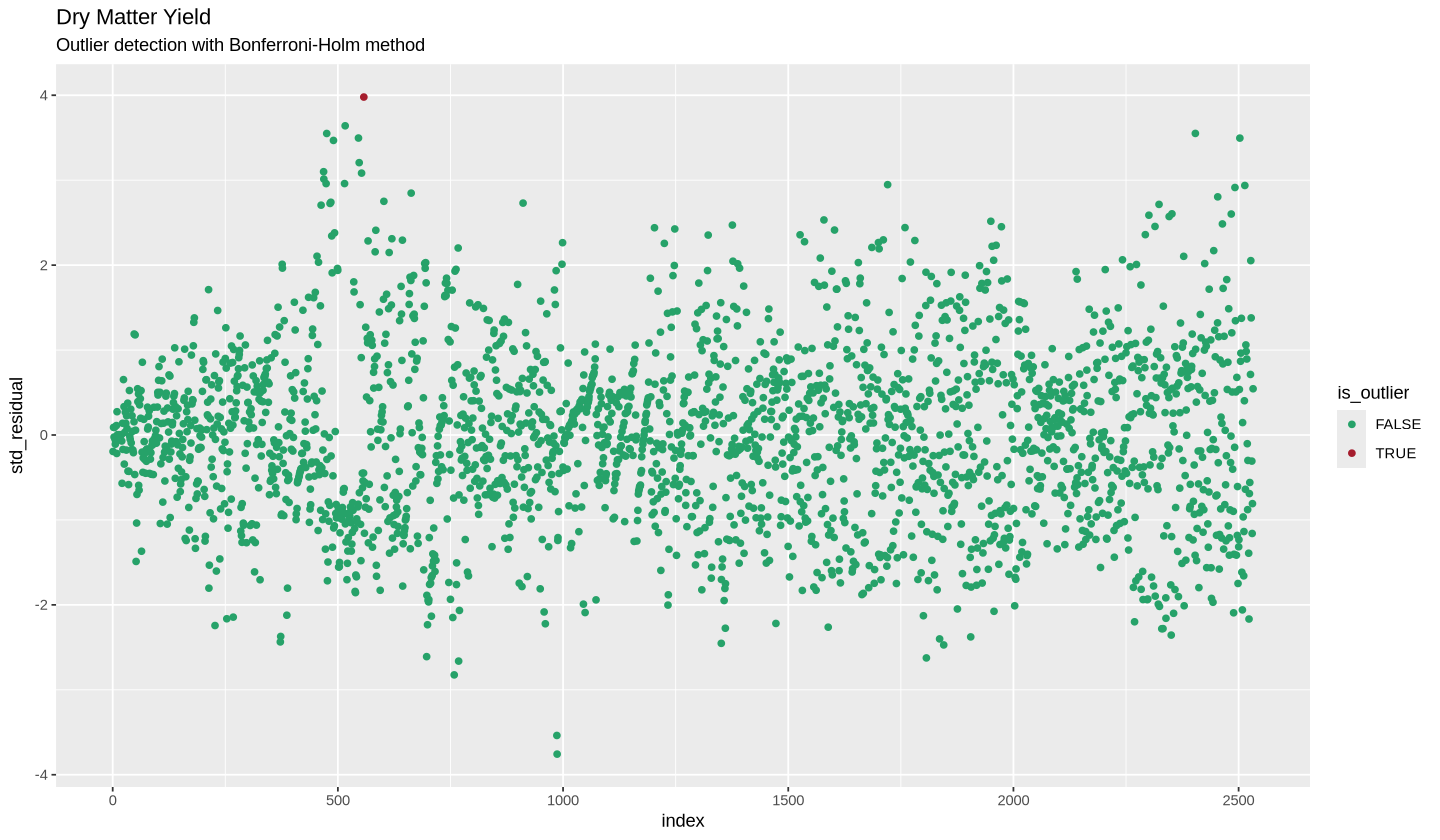

In [26]:
result_BH_DMY <- make_BH_multtest(asreml_res_DMY)

0 outlier value(s) detected for trait Powdery Mildew 


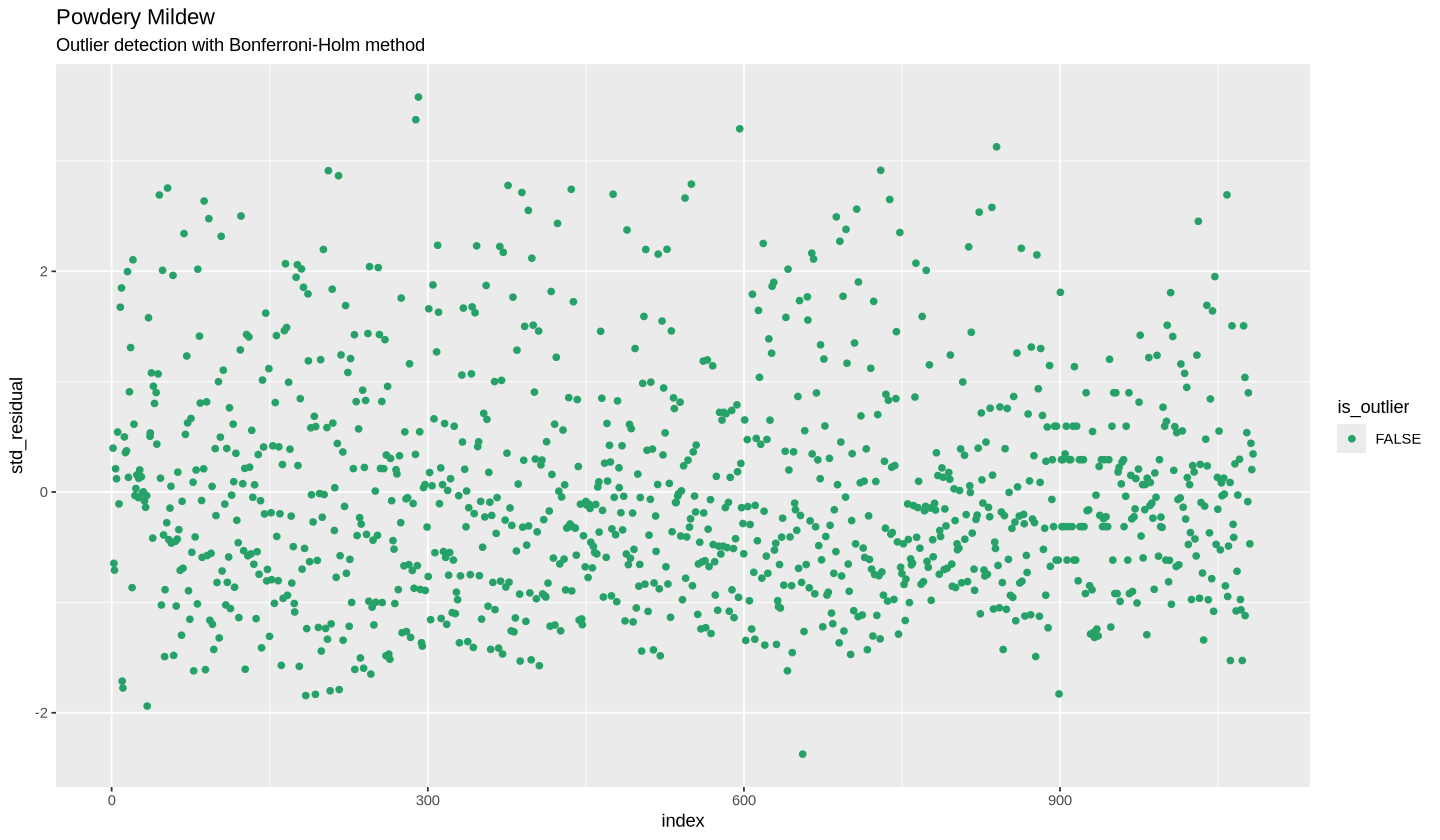

In [27]:
result_BH_PM <- make_BH_multtest(asreml_res_PM)

In [28]:
data_corrected_HT_II <- data_corrected_HT_I |> correct_II(result_BH_HT)
data_corrected_PH_II <- data_corrected_PH_I |> correct_II(result_BH_PH)
data_corrected_PD_II <- data_corrected_PD_I |> correct_II(result_BH_PD)
data_corrected_TKW_II <- data_corrected_TKW_I |> correct_II(result_BH_TKW)
data_corrected_DMY_II <- data_corrected_DMY_I |> correct_II(result_BH_DMY)
data_corrected_PM_II <- data_corrected_PM_I |> correct_II(result_BH_PM)

In [29]:
data_corrected_all <- bind_rows(
    data_corrected_HT_II,
    data_corrected_PH_II,
    data_corrected_PD_II,
    data_corrected_TKW_II,
    data_corrected_DMY_II,
    data_corrected_PM_II,
    ) |> pivot_longer(cols = !c(accenumb,campaign), names_to = "trait") |>
         drop_na() |> arrange(campaign, accenumb, trait)
write_csv(data_corrected_all, "NARDI_wheat_corrected.csv")

## Calculate heritability

In [30]:
asreml_res_h_HT <- asreml(days_to_heading ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_HT_II)

Warning message in asreml(days_to_heading ~ 1, random = ~accenumb + campaign, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration”


In [31]:
asreml_res_h_PH <- asreml(plant_height ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_PH_II)

In [32]:
asreml_res_h_PD <- asreml(plant_density ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_PD_II)

In [33]:
asreml_res_h_TKW <- asreml(thousand_kernel_weight ~1, random = ~accenumb + campaign, 
                    na.action = na.method(x="omit", y="omit"),
                    residual = ~dsum( ~id(units) | campaign), data = data_corrected_TKW_II)

In [34]:
asreml_res_h_DMY <- asreml(dry_matter_yield ~1, random = ~accenumb + campaign, 
                    na.action = na.method(x="omit", y="omit"),
                    residual = ~dsum( ~id(units) | campaign), data = data_corrected_DMY_II)

In [35]:
asreml_res_h_PM <- asreml(powdery_mildew ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_PM_II)

In [36]:
quality_HT <- get_quality(data_sub_HT, asreml_res_h_HT)
quality_PH <- get_quality(data_sub_PH, asreml_res_h_PH)
quality_PD <- get_quality(data_sub_PD, asreml_res_h_PD)
quality_TKW <- get_quality(data_sub_TKW, asreml_res_h_TKW)
quality_DMY <- get_quality(data_sub_DMY, asreml_res_h_DMY)
quality_PM <- get_quality(data_sub_PM, asreml_res_h_PM)

quality_all = bind_rows(quality_HT, quality_PH, quality_PD, quality_TKW, quality_DMY, quality_PM) |> 
                    mutate(across(-1, \(x) round(x, 3)))
write_csv(quality_all,"NARDI_wheat_data_quality.csv")

days_to_heading heritability: 72.4 %


plant_height heritability: 92.2 %


plant_density heritability: 60.1 %


thousand_kernel_weight heritability: 91.2 %


dry_matter_yield heritability: 69.1 %


powdery_mildew heritability: 30.7 %


## Run linear mixed model with outlier corrected data

In [37]:
asreml_data_HT <- asreml(days_to_heading ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_HT_II)

Warning message in asreml(days_to_heading ~ accenumb, random = ~campaign, na.action = na.method(x = "omit", :
“Log-likelihood not converged”


Warning message in asreml(days_to_heading ~ accenumb, random = ~campaign, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration”


In [38]:
asreml_data_PH <- asreml(plant_height ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_PH_II)

In [39]:
asreml_data_PD <- asreml(plant_density ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_PD_II)

In [40]:
asreml_data_TKW <- asreml(thousand_kernel_weight ~accenumb, random = ~campaign, 
                          na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                          data = data_corrected_TKW_II)

Warning message in asreml(thousand_kernel_weight ~ accenumb, random = ~campaign, :
“Some components changed by more than 1% on the last iteration”


In [41]:
asreml_data_DMY <- asreml(dry_matter_yield ~accenumb, random = ~campaign, 
                          na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                          data = data_corrected_DMY_II)

In [42]:
asreml_data_PM <- asreml(powdery_mildew ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_PM_II)

Warning message in asreml(powdery_mildew ~ accenumb, random = ~campaign, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration”


## Extract BLUEs and create output file

In [43]:
BLUEs_HT <- get_BLUEs(asreml_data_HT)
BLUEs_PH <- get_BLUEs(asreml_data_PH)
BLUEs_PD <- get_BLUEs(asreml_data_PD)
BLUEs_TKW <- get_BLUEs(asreml_data_TKW)
BLUEs_DMY <- get_BLUEs(asreml_data_DMY)
BLUEs_PM <- get_BLUEs(asreml_data_PM)


BLUE_all <- genotypes |> left_join(BLUEs_HT, by="genotype") |> 
                        left_join(BLUEs_PH, by="genotype") |> 
                        left_join(BLUEs_PD, by="genotype") |> 
                        left_join(BLUEs_TKW, by="genotype") |> 
                        left_join(BLUEs_DMY, by="genotype") |> 
                        left_join(BLUEs_PM, by="genotype") |>
                        arrange(genotype) |> mutate(across(-1, \(x) round(x, 2)))

write_csv(BLUE_all,"NARDI_wheat_BLUE_values.csv")
summary(BLUE_all)

   genotype         days_to_heading_BLUE plant_height_BLUE plant_density_BLUE
 Length:750         Min.   :133.3        Min.   : 73.12    Min.   :479.0     
 Class :character   1st Qu.:137.4        1st Qu.: 89.30    1st Qu.:567.5     
 Mode  :character   Median :139.3        Median : 96.36    Median :593.5     
                    Mean   :139.6        Mean   : 97.02    Mean   :594.2     
                    3rd Qu.:141.3        3rd Qu.:104.36    3rd Qu.:618.1     
                    Max.   :158.6        Max.   :129.29    Max.   :835.3     
                    NA's   :611          NA's   :611       NA's   :684       
 thousand_kernel_weight_BLUE dry_matter_yield_BLUE powdery_mildew_BLUE
 Min.   :31.11               Min.   :3045          Min.   :0.880      
 1st Qu.:40.02               1st Qu.:5245          1st Qu.:1.715      
 Median :42.90               Median :5743          Median :2.260      
 Mean   :42.56               Mean   :5614          Mean   :2.386      
 3rd Qu.:45.22       

In [44]:
library(rmarkdown)
convert_ipynb("NARDI_historic_wheat_data_analysis.ipynb")

In [45]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 24.04.1 LTS

Matrix products: default
BLAS/LAPACK: /home/erwan/micromamba/envs/R/lib/libopenblasp-r0.3.28.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Paris
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] rmarkdown_2.29      asreml_4.2.0.267    Matrix_1.6-5       
 [4] multtest_2.58.0     Biobase_2.62.0      BiocGenerics_0.48.1
 [7] lubridate_1.9.3     forcats_1.0.0       stringr_1.5.1      
[10] dplyr_1.1.4         purrr_1.0.2